#**Allstate Claims Severity**

## **Bussiness Problem**

Insurance helps the individual/companies to mitigate their risk in unfortunate event,
Insurance premiums need to be decided very carefully. The company issuing the insurance will receive the premiums which will be considered as the income for the company, But at what time they need to bear the expense of providing the coverage is not known beforehand.
 
Traditionally companies hire the professionals known as actuaries, to set the policy premiums according to the risk they are undertaking.

These premium prices can be found out by the ML algorithms which will remove the chances of human error and human bias.

Here, we are given a claim which contains the relevant  information to determine what will be the loss to the company for that particular claim.

Adequate premium prices will mean more business to the insurance company and many sections of the society will be able to mitigate their risks.


## **About the dataset**

Allstate is an american insurance company, which has organised a recruitment kaggle competition in October 2016. At that time Allstate was developing automatic methods of predicting the cost of insurance claims. 


A tabular dataset was given,having around 188k rows where each row is representing an insurance claim [Kaggle dataset](https://www.kaggle.com/c/allstate-claims-severity). The data contains 116 categorical and 14 continuous features. Due to privacy concerns there is no description available for the features,so we do not know what a particular feature represents in the real world. 



**Problem Statement** 

The goal is to predict the value for the  ‘loss’ column,which is a continuous value using various machine learning techniques.


**Business Objective and constraints**


1.   Given a claim recored task is to predict the loss value of a particular claim as accurately as possible.

2.   There is no strict real time prediction requirement.


**Mapping Business problem to Machine learning**


Allstate here wanted to minimise its losses in 2 ways:

1.   Not undercharging the premium to the customer , so that in event of actual claim would be able to pay the claim amount .
2.   Not overcharging the premium to the customer, so that client will switch to the next insurance  company. At the end Allstate will lose customers, which is the loss of potential business.





**Performance metric**

Upon doing the EDA found out that many claims are of low value. 
So will first classify the claim record as *low loss/ not low loss*  by doing a binary classification task.For the classification task we will select the **accuracy** as our performance metric.


Then for both the classes will build the Regression models separately to predict the loss given a claim record.As our task is to predict the loss value as close as possible, we will select the **Mean Absolute Error(MAE)** as our performance metric.


**Mean Absolute Error(MAE)** = It is the mean of absolute value of the difference between the (actual value and predicted value).




#### Downloading the dataset from kaggle

In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
!kaggle competitions download -c allstate-claims-severity

Extracting the zipped files

In [ ]:
!unzip train.csv.zip 
!unzip test.csv.zip 

Archive:  train.csv.zip
  inflating: train.csv               
Archive:  test.csv.zip
  inflating: test.csv                


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import warnings
import sklearn
warnings.filterwarnings('ignore')

In [ ]:
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

For the test_data , we need to predict the loss value. so for training the model dividing the training data into (train ,test and CV sets)


In [ ]:
counts_categorical = []
continous_features = []
categorical_features = []
for i in train_data.columns: # counting the number of categorical and continous features
    if 'cat' in i:
        #categorical_features_count += 1
        counts_categorical.append(len(train_data[i].value_counts()))  # counting the number of classes for each variable
        categorical_features.append(i)
    elif 'cont' in i:
        continous_features.append(i)
        #continous_features_count += 1

print(" In in data set we have {} categorical and {} continuous valued features".format(len(categorical_features),len(continous_features)))


 In in data set we have 116 categorical and 14 continuous valued features


In [ ]:
print("In the train dataset there are {} claim records and in test dataset  there are {} claim records".format(len(train_data),len(test_data)))

In the train dataset there are 188318 claim records and in test dataset  there are 125546 claim records


In [ ]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188318 entries, 0 to 188317
Columns: 132 entries, id to loss
dtypes: float64(15), int64(1), object(116)
memory usage: 189.7+ MB


In [ ]:
print(train_data.shape)
train_data.drop_duplicates()
print(train_data.shape)

(188318, 132)
(188318, 132)


As there same of the train_data is same before and after the drop dublicates so there are no duplicate in train dataset.

In [ ]:
train_data.isna().any().any()
#  train_data.isna() returns the full data frame with boolean values
# train_data.isna().any() return the series with all the column names and wheather it contains any of the NA values or not
# train_data.isna().any().any()  returns the single bool value wheather the whole dataframe has any NA vlaues or not

False

There is no missing value in the dataset.

In [ ]:
train_data.describe()

,id,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,cont14,loss
count,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000
mean,294135.982561,0.493861,0.507188,0.498918,0.491812,0.487428,0.490945,0.484970,0.486437,0.485506,0.498066,0.493511,0.493150,0.493138,0.495717,3037.337686
std,169336.084867,0.187640,0.207202,0.202105,0.211292,0.209027,0.205273,0.178450,0.199370,0.181660,0.185877,0.209737,0.209427,0.212777,0.222488,2904.086186
min,1.000000,0.000016,0.001149,0.002634,0.176921,0.281143,0.012683,0.069503,0.236880,0.000080,0.000000,0.035321,0.036232,0.000228,0.179722,0.670000
25%,147748.250000,0.346090,0.358319,0.336963,0.327354,0.281143,0.336105,0.350175,0.312800,0.358970,0.364580,0.310961,0.311661,0.315758,0.294610,1204.460000
50%,294539.500000,0.475784,0.555782,0.527991,0.452887,0.422268,0.440945,0.438285,0.441060,0.441450,0.461190,0.457203,0.462286,0.363547,0.407403,2115.570000
75%,440680.500000,0.623912,0.681761,0.634224,0.652072,0.643315,0.655021,0.591045,0.623580,0.566820,0.614590,0.678924,0.675759,0.689974,0.724623,3864.045000
max,587633.000000,0.984975,0.862654,0.944251,0.954297,0.983674,0.997162,1.000000,0.980200,0.995400,0.994980,0.998742,0.998484,0.988494,0.844848,121012.250000


All the continous values are in the range of 0 to 1. But mean is not 0 and std is also not 1. So here min max scaling might have been used to bring to 0 to 1 scale.

Mean of the loss is 3037.33 and Standard deviation is 2904.08

Text(0.5, 1.0, 'Distribution of categorical features for number of classes')

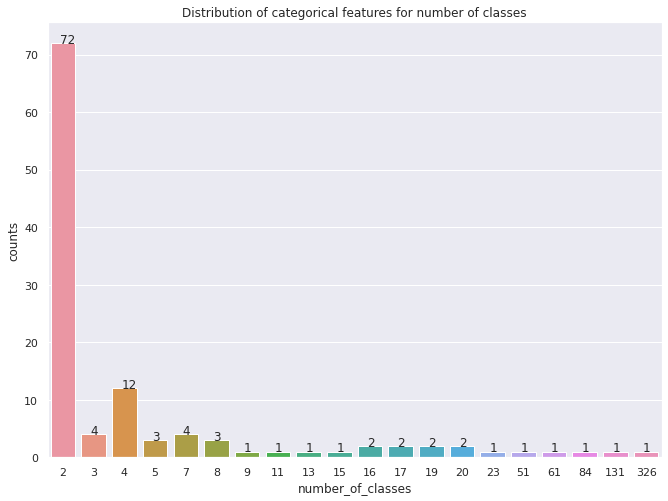

In [ ]:
#ref : https://stackoverflow.com/a/59840744/5305748  for anotating bargraph
from collections import Counter
k = Counter(counts_categorical)
k = dict(k)
k = pd.DataFrame({'number_of_classes':list(k.keys()),'counts': list(k.values()) })
sns.set(rc={'figure.figsize':(11.0,8.0)})
g = sns.barplot(x= 'number_of_classes', y='counts',data=k)

for p in g.patches:
        g.annotate('{:.0f}'.format(p.get_height()), (p.get_x()+0.3, p.get_height()))
        
plt.title("Distribution of categorical features for number of classes")

There are 72 two classes features and majority of the features have less than 8 classes per feature.And the maximum is 326 classes for a single feature.

# Univariate Analysis

In [ ]:
categorical_unvarivate = []
for i,x in enumerate(categorical_features):
    if counts_categorical[i] <3:
        categorical_unvarivate.append(x)


In [ ]:
def piechart_categorical(categorical_features,x,y):
    """" Fucntion to plot the  pie chart of the categorical features"""
    sns.set(rc={'figure.figsize':(25.0,5.0)})
    k=0
    fig, axs = plt.subplots(1, 5)
    for i in categorical_features[x:y]:
        
        l = list(train_data[i].value_counts().index)
        axs[k].pie(train_data[i].value_counts(),labels=l, textprops={'fontsize': 16}, autopct='%1.1f%%')  # autopct is automatic percentage
        
        axs[k].set_title('for categorical feature -' + str(i),fontdict={'fontsize':16})
        k +=1 
    plt.show()

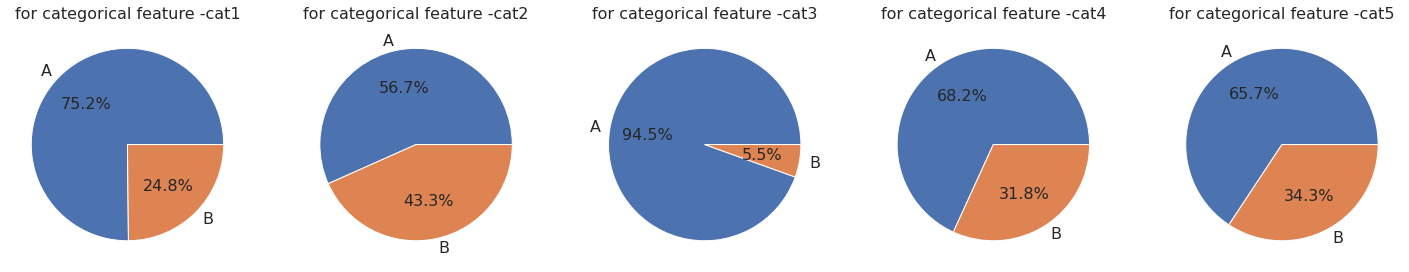

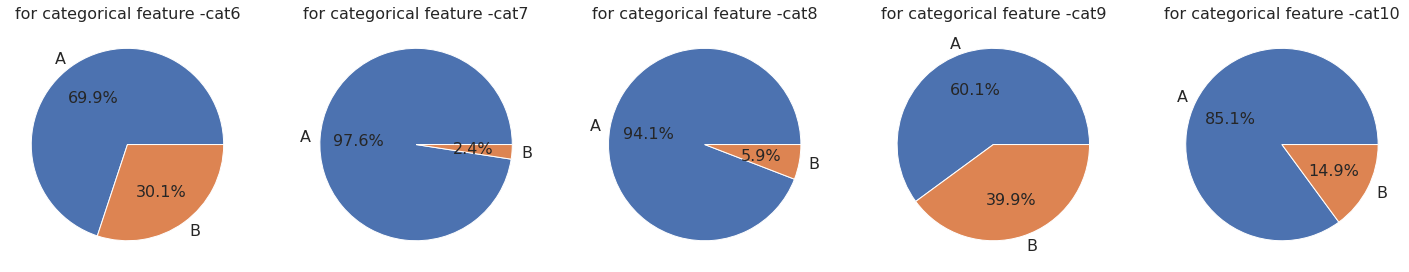

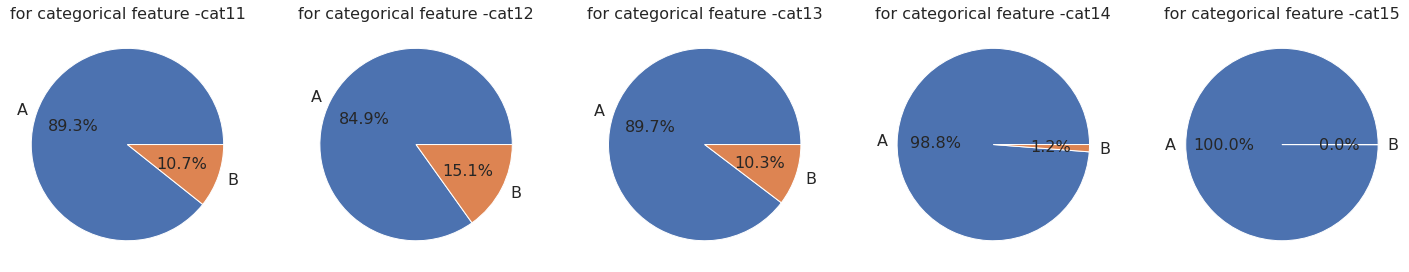

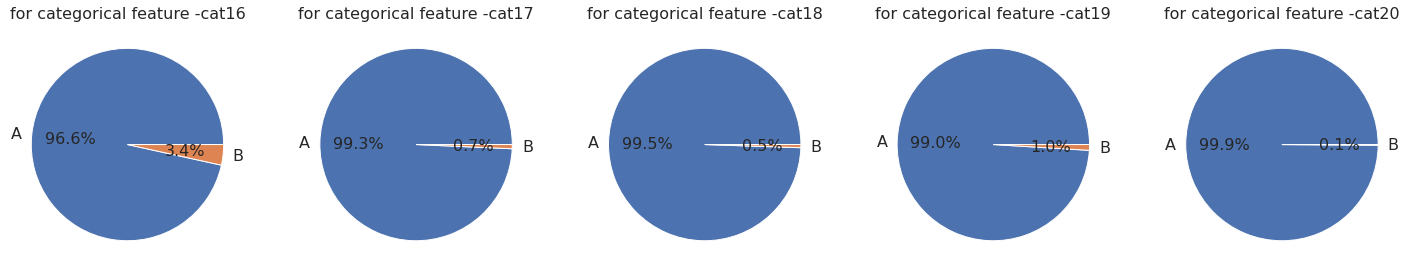

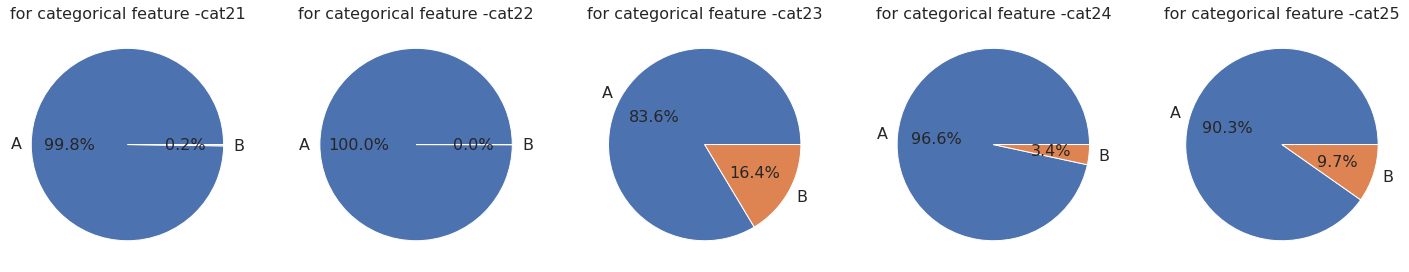

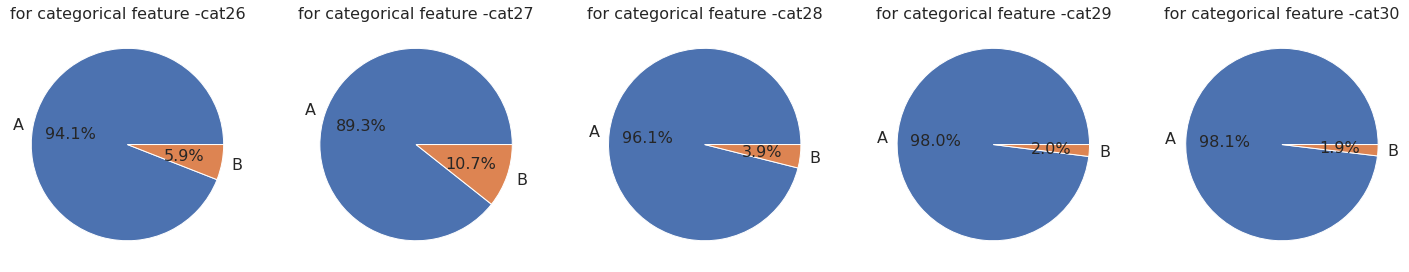

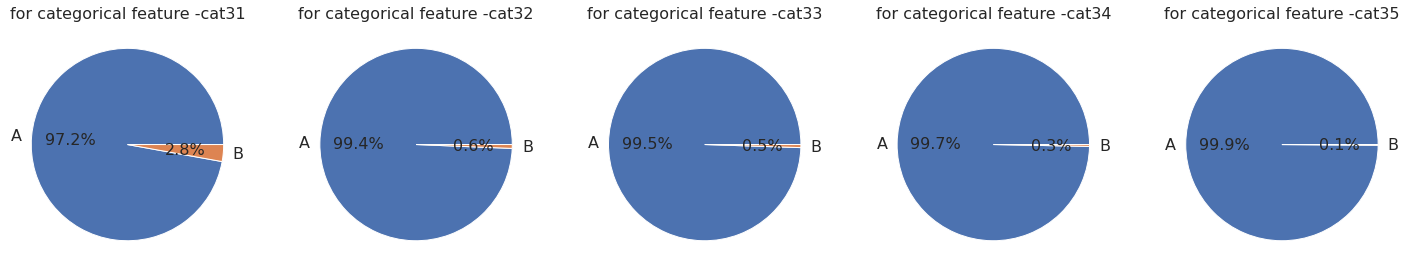

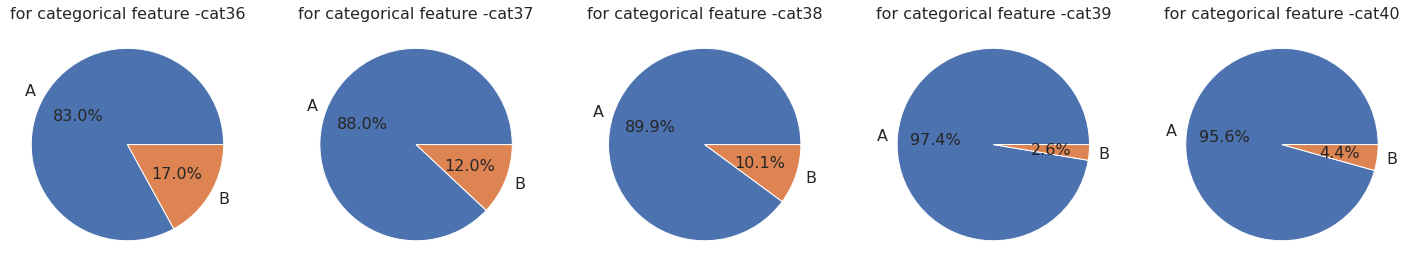

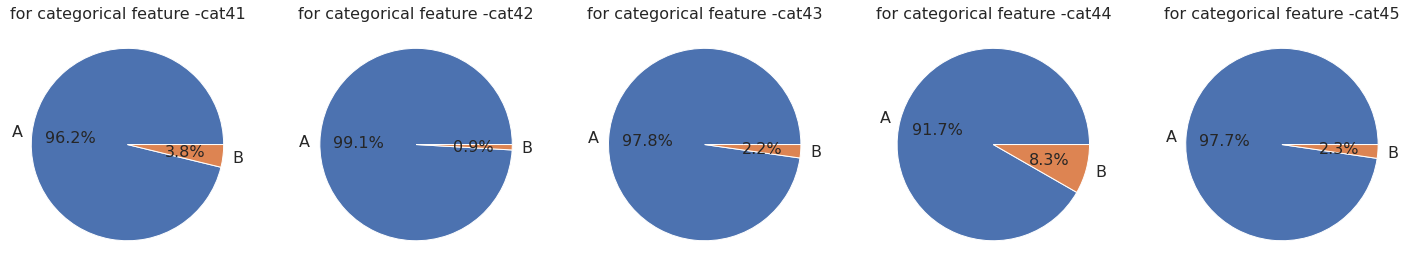

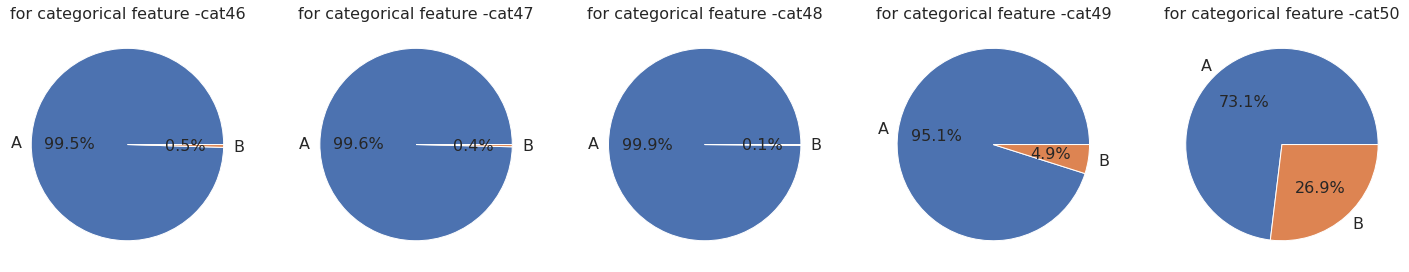

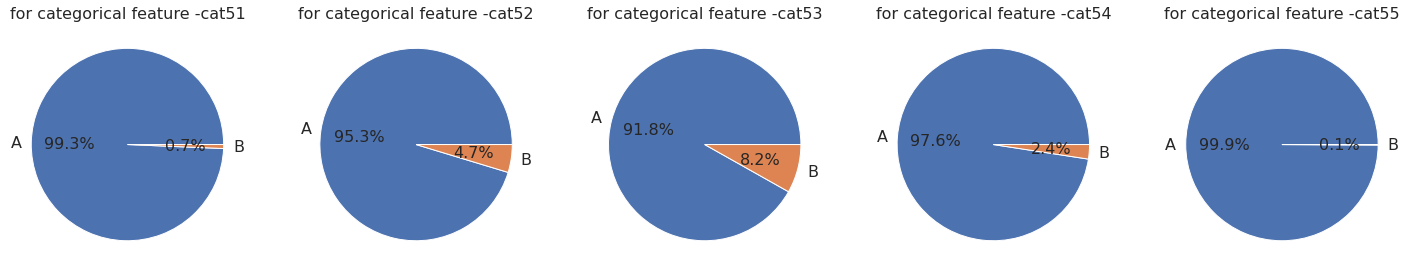

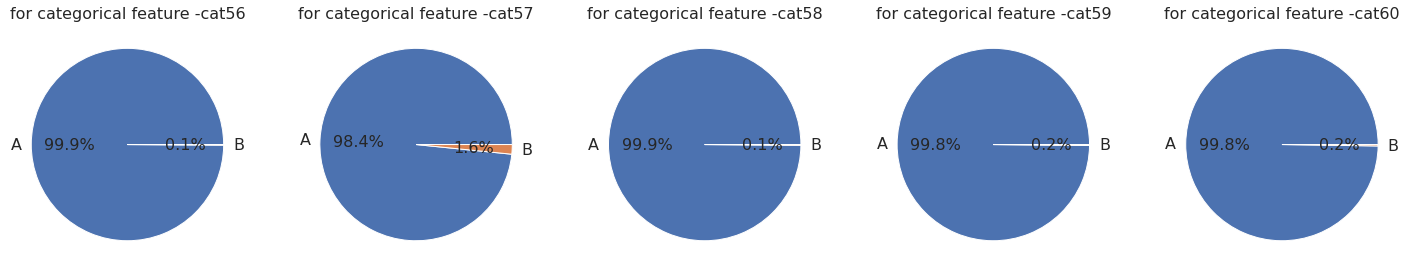

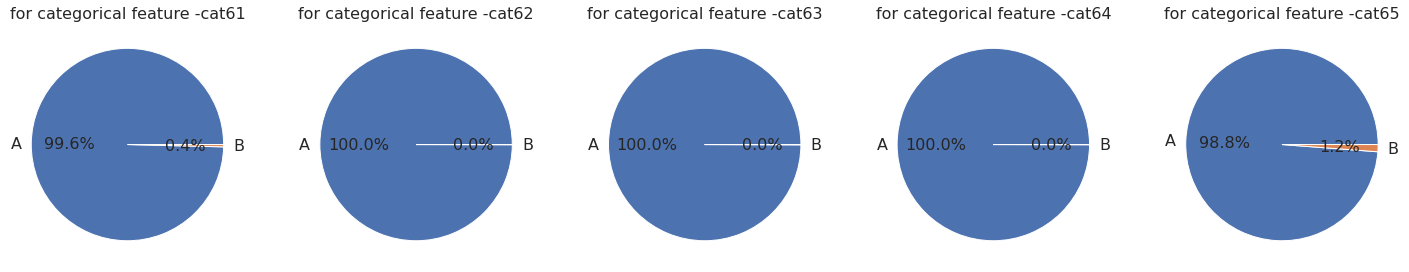

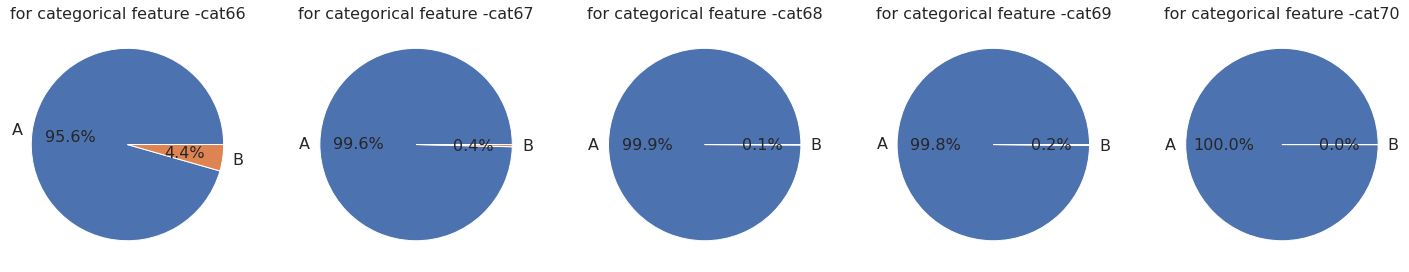

In [ ]:
for i in range(int(len(categorical_unvarivate)/5)):
    piechart_categorical(categorical_unvarivate,i*5,(i+1)*5)

For the majority of the categorical classes there is one class having more than half of the data points as the majority class.
 
To the extent 100% of the data belongs to a single class.
As the Target loss variable is also skewed, here we will not remove the features which are skewed.


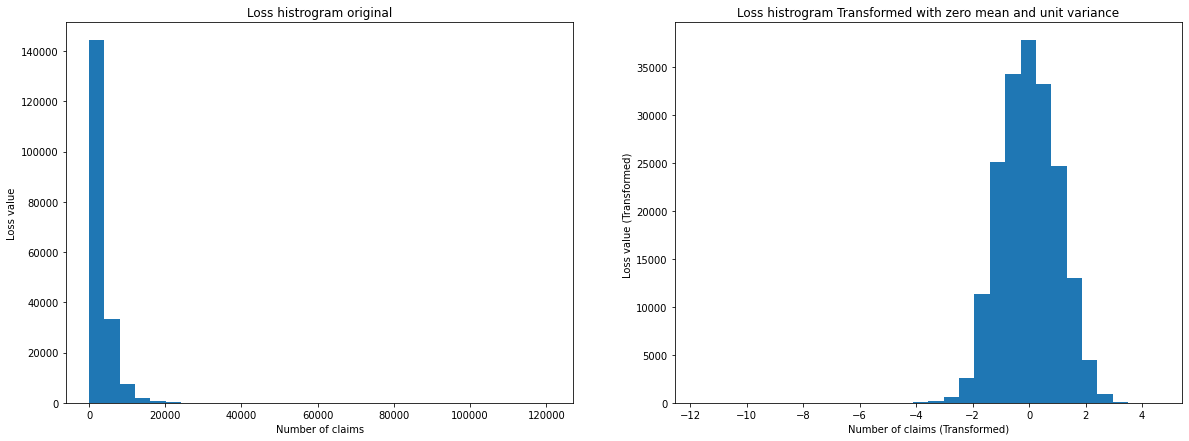

In [ ]:
from sklearn.preprocessing import power_transform

transformed_loss = power_transform(train_data['loss'].values.reshape(-1,1), method='box-cox')
fig, axs = plt.subplots(1,2,figsize = (20,7) )


axs[0].hist(train_data['loss'].values.reshape(-1,1),bins=30)
axs[0].set_title("Loss histrogram original")
axs[0].set_xlabel("Number of claims")
axs[0].set_ylabel("Loss value")

axs[1].hist(transformed_loss,bins=30)
axs[1].set_title("Loss histrogram Transformed with zero mean and unit variance")
axs[1].set_xlabel("Number of claims (Transformed)")
axs[1].set_ylabel("Loss value (Transformed) ")


plt.show()



In [ ]:
np.exp(np.percentile(transformed_loss,0))

8.03002603956418e-06

Loss feature is of power law distribution. so transformed using box cox transformation.


As there many features analysing each one is not appropriate.

In [ ]:
X= pd.get_dummies(data= train_data[categorical_features])
y = train_data['loss']

In [ ]:
from sklearn.feature_selection import SelectKBest, f_regression

select_K = SelectKBest(score_func= f_regression, k=15).fit(X, y)


In [ ]:
select_K.get_support() # returns the boolean array wheather the feature is selected or not.

# ref : https://seaborn.pydata.org/tutorial/categorical.html
X.iloc[:1,select_K.get_support()].columns  # seeing which columns have the more feature importance 

Index(['cat7_A', 'cat7_B', 'cat10_A', 'cat10_B', 'cat12_A', 'cat12_B',
       'cat57_A', 'cat57_B', 'cat79_B', 'cat79_D', 'cat80_B', 'cat80_D',
       'cat81_D', 'cat87_B', 'cat89_A'],
      dtype='object')

features cat7,cat10,cat12,cat57,cat79,cat80,cat81,cat87,cat89  are important features(In no particular order).

Here all the features tunned out to be categorical features. (because only categorical features are inputed to the model.)

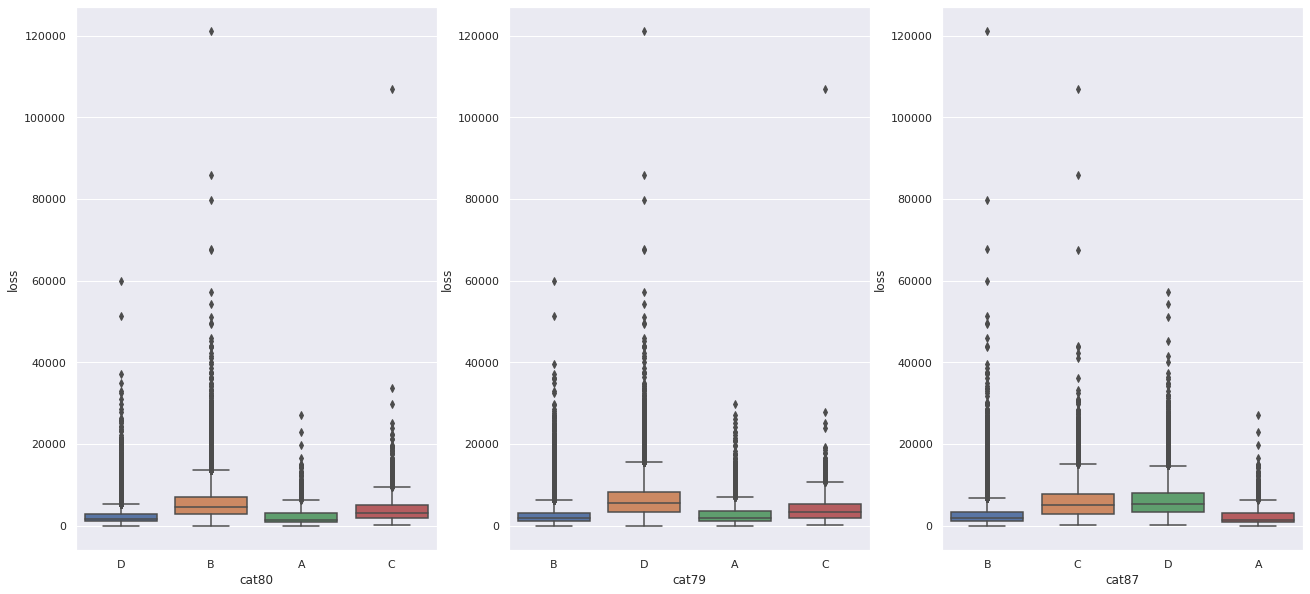

In [ ]:
# ref : https://seaborn.pydata.org/tutorial/categorical.html

fig, axs = plt.subplots(1,3,figsize = (22,10) )

sns.boxplot(x="cat80", y="loss",data = train_data, ax= axs[0])  # ax argument does not works with catplot
sns.boxplot(x="cat79", y="loss",data = train_data,  ax= axs[1])
sns.boxplot(x="cat87", y="loss",data = train_data,  ax= axs[2])

For the cat80 , if a claim belongs to class A and C then loss value is not significantly higher.And class B have higher loss compared to the other classes.


For the cat79, again if claim belongs to class A and C then the loss outliers are much smaller than other class. Class D have higher loss then other classes.class B have less deviation around the median value.


For the cat87 ,Class A have the loss smaller then other classes.

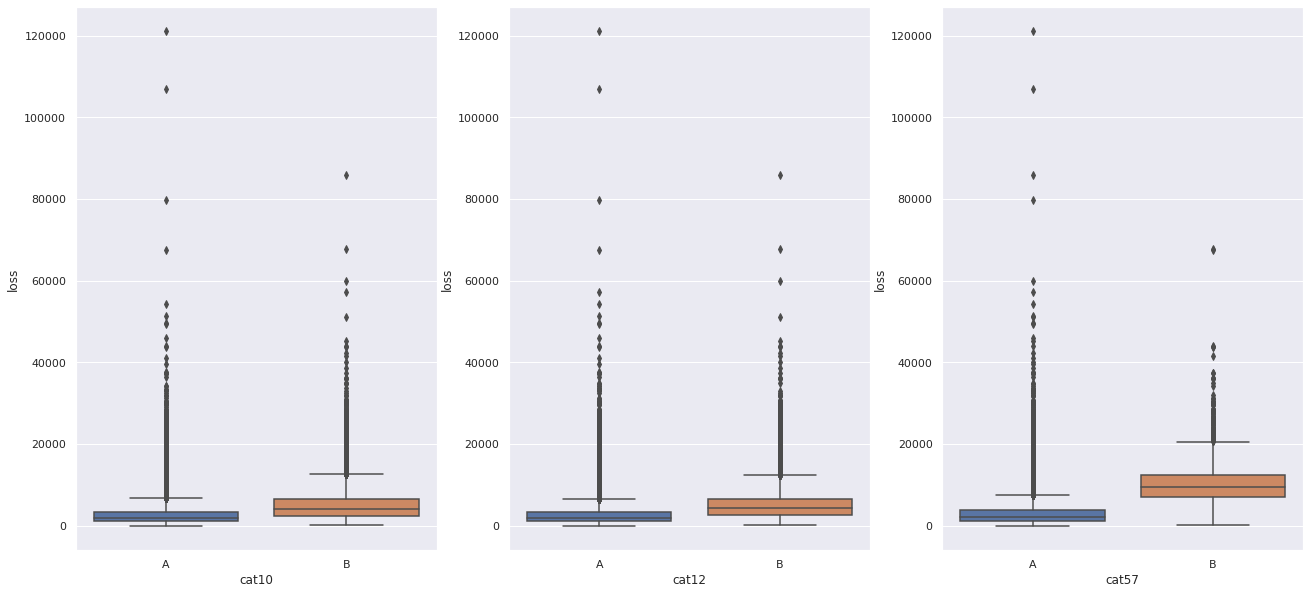

In [ ]:
fig, axs = plt.subplots(1,3,figsize = (22,10) )

sns.boxplot(x="cat10", y="loss",data = train_data, ax= axs[0]) 
sns.boxplot(x="cat12", y="loss",data = train_data,  ax= axs[1])
sns.boxplot(x="cat57", y="loss",data = train_data,  ax= axs[2])


For the cat10, class B have the higher loss and more variance around  median than class A.

For the cat12, again here class B have higher loss then class A . also class B have more variance.

For the cat57 ,the variance around median for the class A is much smaller than class B. And class B have the more  loss in comparison.


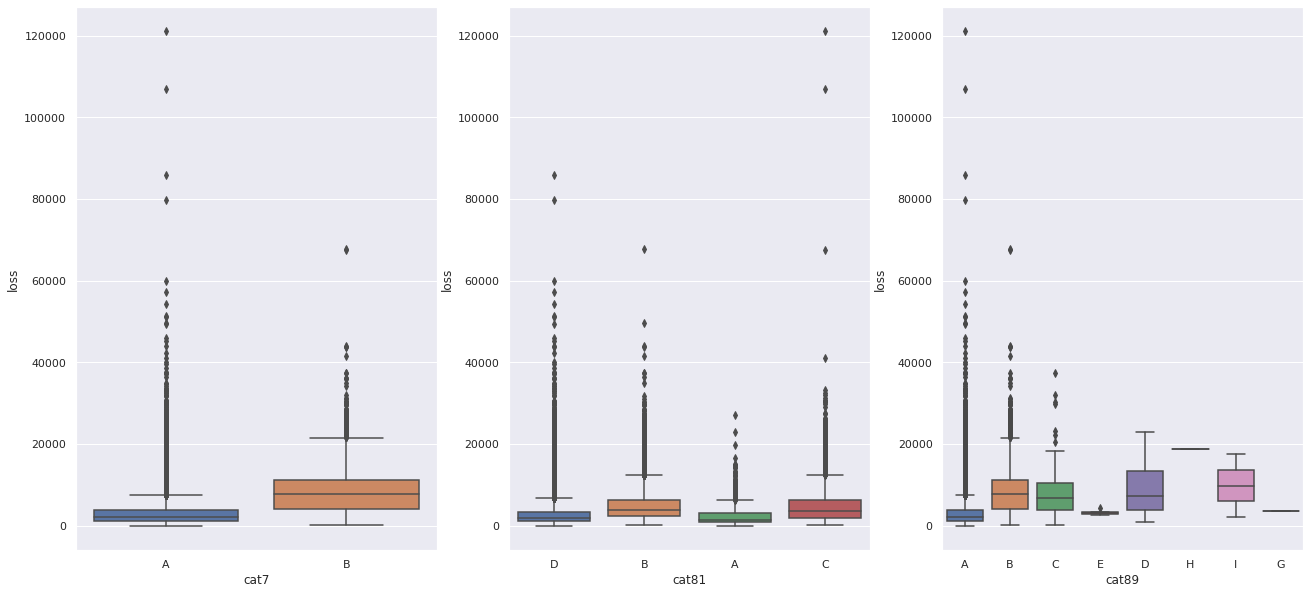

In [ ]:

fig, axs = plt.subplots(1,3,figsize = (22,10) )

sns.boxplot(x="cat7", y="loss",data = train_data, ax= axs[0])  
sns.boxplot(x="cat81", y="loss",data = train_data,  ax= axs[1])
sns.boxplot(x="cat89", y="loss",data = train_data,  ax= axs[2])

For cat7, Class B have higher loss and more spread of losses then class A.

For cat81, Majority of the losses for the classes D and A are less in comparision to class B and C.


Or the cat89, the CLasses E and G have small losses without any outliers.
class H have significantly higher losses than other classes.

for almost all the categorical features there are outlier, but we cannot ignore or remove them as they represents the geniune claims of the customers.

Text(0.5, 1.0, 'Histogram for cont3 feature')

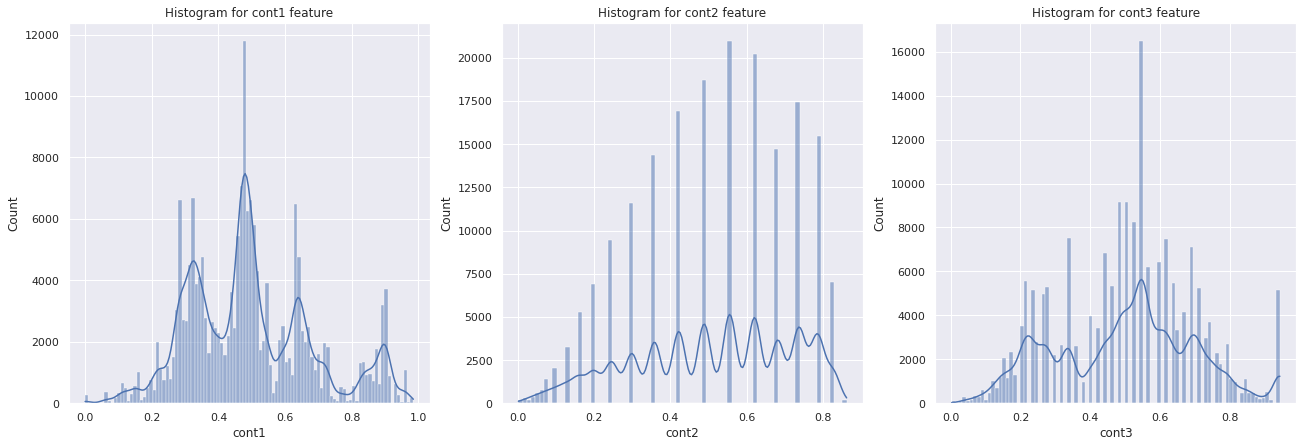

In [ ]:
fig, axs = plt.subplots(1,3,figsize = (22,7) )

sns.histplot(x="cont1",data = train_data, ax= axs[0],kde=True)
axs[0].set_title("Histogram for cont1 feature")  
sns.histplot(x="cont2",data = train_data,  ax= axs[1],kde=True)
axs[1].set_title("Histogram for cont2 feature") 
sns.histplot(x="cont3",data = train_data,  ax= axs[2],kde=True)
axs[2].set_title("Histogram for cont3 feature") 

Text(0.5, 1.0, 'Histogram for cont6 feature')

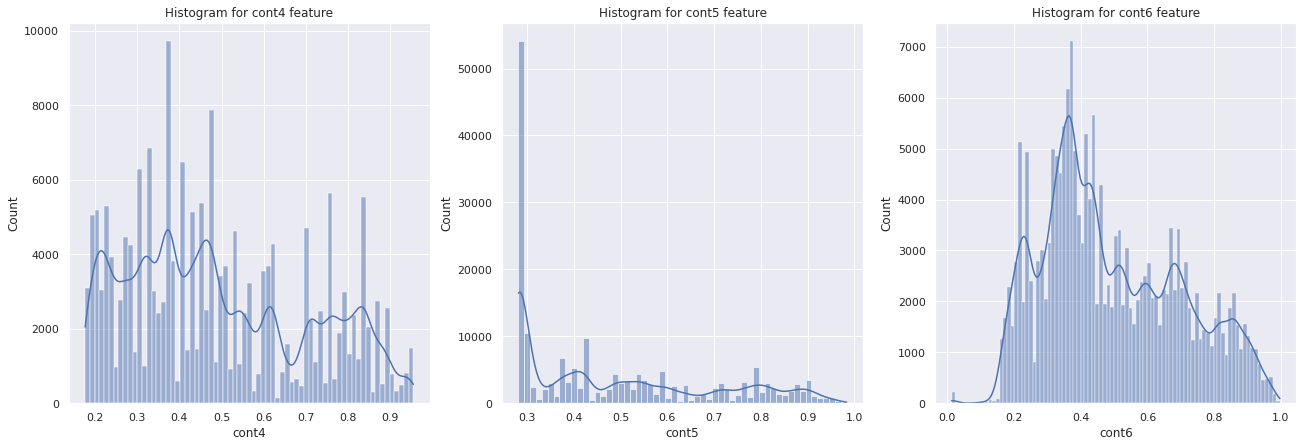

In [ ]:
fig, axs = plt.subplots(1,3,figsize = (22,7) )

sns.histplot(x="cont4",data = train_data, ax= axs[0],kde=True)
axs[0].set_title("Histogram for cont4 feature")   
sns.histplot(x="cont5",data = train_data,  ax= axs[1],kde=True)
axs[1].set_title("Histogram for cont5 feature") 
sns.histplot(x="cont6",data = train_data,  ax= axs[2],kde=True)
axs[2].set_title("Histogram for cont6 feature") 

Text(0.5, 1.0, 'Histogram for cont9 feature')

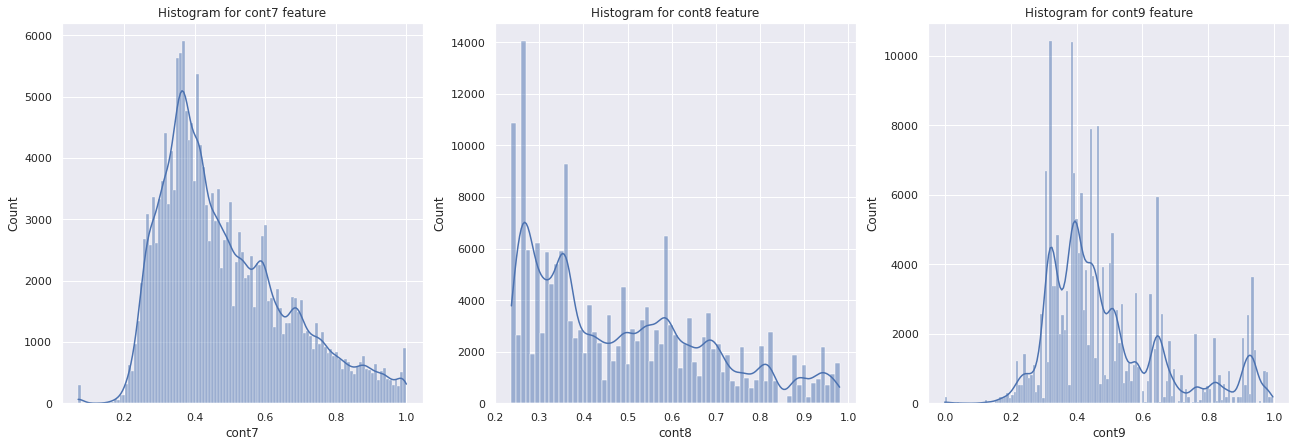

In [ ]:
fig, axs = plt.subplots(1,3,figsize = (22,7) )

sns.histplot(x="cont7",data = train_data, ax= axs[0],kde=True) 
axs[0].set_title("Histogram for cont7 feature")  
sns.histplot(x="cont8",data = train_data,  ax= axs[1],kde=True)
axs[1].set_title("Histogram for cont8 feature") 
sns.histplot(x="cont9",data = train_data,  ax= axs[2],kde=True)
axs[2].set_title("Histogram for cont9 feature") 

Text(0.5, 1.0, 'Histogram for cont12 feature')

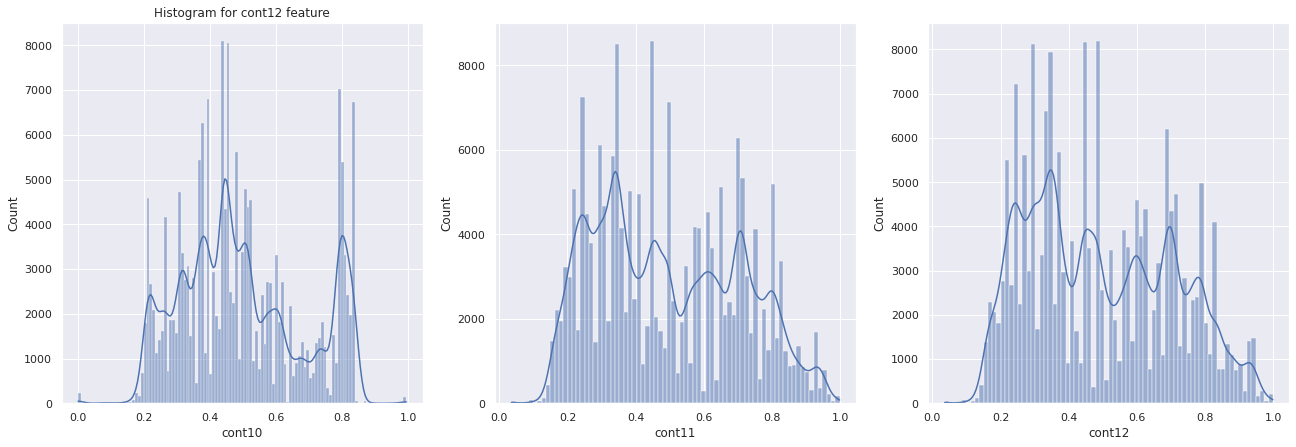

In [ ]:
fig, axs = plt.subplots(1,3,figsize = (22,7) )

sns.histplot(x="cont10",data = train_data, ax= axs[0],kde=True)
axs[0].set_title("Histogram for cont10 feature")   
sns.histplot(x="cont11",data = train_data,  ax= axs[1],kde=True)
axs[0].set_title("Histogram for cont11 feature") 
sns.histplot(x="cont12",data = train_data,  ax= axs[2],kde=True)
axs[0].set_title("Histogram for cont12 feature") 

Text(0.5, 1.0, 'Histogram for cont14 feature')

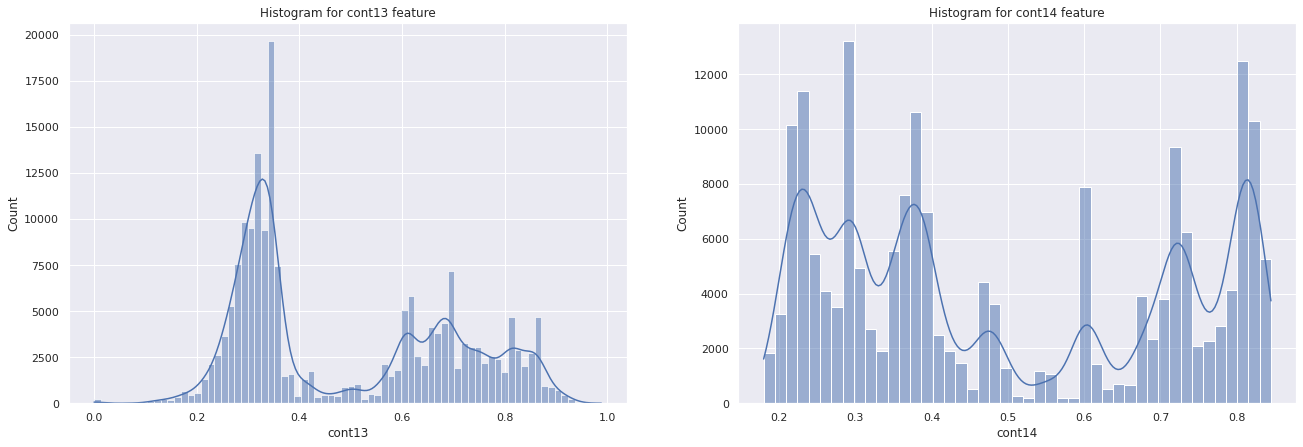

In [ ]:
fig, axs = plt.subplots(1,2,figsize = (22,7) )

sns.histplot(x="cont13",data = train_data, ax= axs[0],kde=True)
axs[0].set_title("Histogram for cont13 feature")  
sns.histplot(x="cont14",data = train_data,  ax= axs[1],kde=True)
axs[1].set_title("Histogram for cont14 feature")


Apart from cont7 and cont6 features none of the categorical features are in normal distribution. 
Can try to use mean centering and variance scaling here.

# Bi-Varriate Analysis

In [ ]:
sns.set(rc={'figure.figsize':(15.0,15.0)})
sns.pairplot(train_data[continous_features + ['loss']],corner=True)

There is linear relation among the cont1 with - cont6, cont9,cont10.
Also very strong correlation between cont11 and cont12.


For all the continous features the loss value distribution is very dense on the lower loss and very few points on having the larger loss.

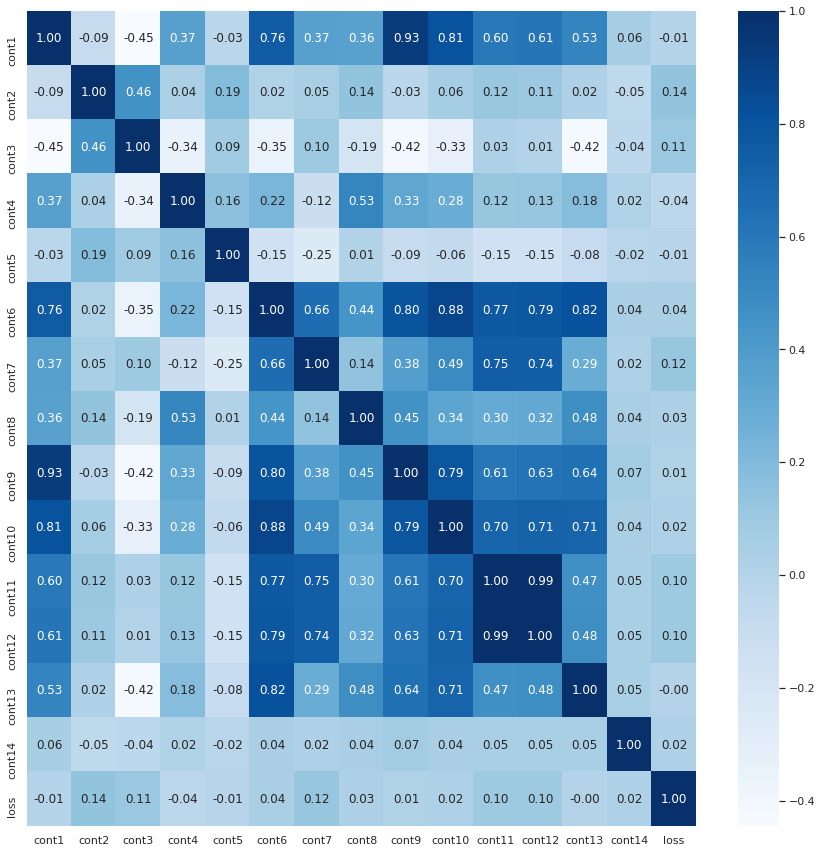

In [ ]:
sns.heatmap(train_data[continous_features + ['loss']].corr(), annot=True, fmt='.2f',cmap= 'Blues', )

Observation:
Very strong correlation between features 

1.   cont11 and cont12

2.   cont1 and cont9

There are some negatively correlated pair of features as well
1.   cont13 and cont3


2.   cont9 and cont3

3. cont1 and cont3

These features with low corelation may be combined to check for any improvement on the CV results.




# Spliting of Data

As in the test data file we do not have the target feature(loss value), so to check for model performance spliting the train data given into train,test and CV.

In [ ]:

from sklearn.model_selection import train_test_split
y = train_data['loss']
X = train_data.drop(columns=['loss'])

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2 , random_state=42)

#X_test,X_cv,y_test,y_cv = train_test_split(X_test,y_test, test_size=0.5 , random_state=42)

In [ ]:
SHIFT = 200
y_train = np.log(y_train) + SHIFT
y_test = np.log(y_test) + SHIFT

In [ ]:
len(X_train),len(X_test)

(150654, 37664)

# Feature Engineering


In [ ]:
# mean centering and unit variance.
def calculate_zscore(df,continous_features):

    # copying only the continous features from the dataframe
    df = df[continous_features].copy()
    for col in continous_features:
        df[col] = ( df[col] - df[col].mean())/df[col].std()
    return df

train_data['cont1']


In [ ]:
calculate_zscore(X_train,continous_features).describe()

In [ ]:
from sklearn.preprocessing import OneHotEncoder
def one_hot_encoding(df,categorical_features):
    """ Fuction to return one hot encoder """
    df = df[categorical_features].copy()
    ohe = OneHotEncoder(handle_unknown='ignore')
    ohe.fit(df)
    return ohe




In [ ]:
from sklearn.preprocessing import OrdinalEncoder
def label_categorical_encoding(df,categorical_features):
    """ Fuction to return the label_encode_dict containing the label encoder for each col in the categorical features """
    df = df[categorical_features].copy()
    label_encode_dict = dict()
    for col in df.columns:
        label_encode = OrdinalEncoder(handle_unknown = 'use_encoded_value', unknown_value = -3)
        label_encode.fit(df[col].values.reshape(-1,1))
        label_encode_dict[col] = label_encode

    return label_encode_dict

In [ ]:
#one  hot encodeing of the categorical features
encoder_ohe = one_hot_encoding(X_train,categorical_features)
X_cat = encoder_ohe.transform(X_train[categorical_features])
X_cat_test = encoder_ohe.transform(X_test[categorical_features])


In [ ]:
# Run if one hot encoded the data
X_cat = X_cat.toarray()
X_cat_test = X_cat_test.toarray()

In [ ]:
#Label encodeing of the categorical features  OrdinalEncoder
X_cat = X_train[categorical_features]
X_cat_test = X_test[categorical_features] 

label_encode_dict = label_categorical_encoding(X_train,categorical_features)
for col,encoder in label_encode_dict.items():
    X_cat[col] = encoder.transform(X_train[col].values.reshape(-1,1))
    X_cat_test[col] = encoder.transform(X_test[col].values.reshape(-1,1))

In [ ]:
# run if Label encoded the data
X_cat = X_cat.to_numpy()
X_cat_test = X_cat_test.to_numpy()

**Observation: **

One hot encoding did not work out well after training the model.

In [ ]:
def encode_continous(df,continous_features):
    for col in continous_features:
        df[col +'_log'] = np.log1p(df[col])  # Log transformed
        df[col + '_squareroot'] = np.sqrt(df[col])  # Square root
        df[col + '_square'] = np.square(df[col])  # Square
        df[col + '_log2'] = np.log2(df[col])  # log2


def encode_category(df,categorical_features):
    for col in categorical_features:
        unique_classes = sorted(df[col].unique())
        encoded_class = dict()

        for c in unique_classes:
            if len(c) == 2:
                encoded_class[c] = ord(c[0]) + ord(c[1]) - (2*65)  
                continue 
            encoded_class[c] = ord(c) - 65
        df[col].replace(encoded_class ,inplace = True)
    

In [ ]:
encode_continous(X_train,continous_features)
encode_continous(X_test,continous_features)
encode_category(X_train,categorical_features)
encode_category(X_test,categorical_features)

### Adding polynomical feature interactions

In [ ]:
k = poly.fit_transform(X_train[continous_features])
k.shape

(150654, 120)

In [ ]:
k[:,1].shape

(150654,)

In [ ]:
X_con = X_train[continous_features].to_numpy()
X_con_test = X_test[continous_features].to_numpy()
X_con.shape

(150654, 14)

In [ ]:
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(2)   # There is no performace improment of having polynomial of degree 3
X_con = poly.fit_transform(X_con)
X_con_test = poly.transform(X_con_test)

In [ ]:
X_con.shape, X_con_test.shape

((150654, 120), (37664, 120))

# PCA


In [ ]:
from sklearn.decomposition import PCA

X_pca = np.hstack((X_con,X_cat))  # did not work with the one sparse matrix
pca = PCA(n_components=20)
pca.fit(X_pca)

PCA(copy=True, iterated_power='auto', n_components=20, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [ ]:
print(pca.explained_variance_)
print(pca.explained_variance_ratio_)

[2.35154011 2.0085094  1.33360039 1.07081709 0.93789653 0.85301854
 0.78585513 0.73253702 0.57646378 0.52337216 0.50127435 0.47667501
 0.4375088  0.42108877 0.39689408 0.32907901 0.31447881 0.30535877
 0.28352583 0.26869016]
[0.08142671 0.0695486  0.04617854 0.03707915 0.03247652 0.02953745
 0.02721178 0.02536554 0.01996119 0.01812279 0.01735761 0.01650581
 0.0151496  0.01458103 0.01374324 0.01139501 0.01088945 0.01057365
 0.00981764 0.00930393]


We can see the explained variance for top 2 principle components is above 2, and top 4 principle components have only the variance above 1.
 
There is no principle component having large explained variance.
Also the top principle component have variance of 8.14% among the 20 components


## Auto encoders


In [ ]:
import tensorflow as tf

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model

# ref: https://www.tensorflow.org/tutorials/generative/autoencoder#first_example_basic_autoencoder
#ref: https://machinelearningmastery.com/autoencoder-for-classification/

In [ ]:
latent_dim = 100   # latent_dim will be set based on the CV performance

class Autoencoder(Model):
    def __init__(self, latent_dim):
        super(Autoencoder, self).__init__()
        self.latent_dim = latent_dim   
        self.encoder = tf.keras.Sequential([
            layers.Flatten(),
            layers.Dense(latent_dim*3, activation='relu'),
            layers.Dense(latent_dim*2, activation='relu'),
            layers.Dense(latent_dim, activation='relu')
        ])
        self.decoder = tf.keras.Sequential([
            layers.Dense(236, activation='sigmoid') 
        ])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

autoencoder = Autoencoder(latent_dim)

In [ ]:
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

In [ ]:
X_test = np.hstack((X_con_test,X_cat_test))
X_train = np.hstack((X_con,X_cat))

print (X_train.shape)
print (X_test.shape)

autoencoder.fit(X_train, X_train,
                epochs=10,
                shuffle=True,
                validation_data=(X_test, X_test))

(150654, 236)
(37664, 236)
Epoch 1/10
4708/4708 [==============================] - 22s 4ms/step - loss: 152.5393 - val_loss: 152.7909
Epoch 2/10
4708/4708 [==============================] - 21s 4ms/step - loss: 152.4067 - val_loss: 152.7895
Epoch 3/10
4708/4708 [==============================] - 21s 4ms/step - loss: 151.9616 - val_loss: 152.7892
Epoch 4/10
4708/4708 [==============================] - 20s 4ms/step - loss: 152.5594 - val_loss: 152.7889
Epoch 5/10
4708/4708 [==============================] - 19s 4ms/step - loss: 152.5259 - val_loss: 152.7888
Epoch 6/10
4708/4708 [==============================] - 21s 4ms/step - loss: 152.5926 - val_loss: 152.7884
Epoch 7/10
4708/4708 [==============================] - 21s 5ms/step - loss: 152.7229 - val_loss: 152.7884
Epoch 8/10
4708/4708 [==============================] - 19s 4ms/step - loss: 152.1976 - val_loss: 152.7884
Epoch 9/10
4708/4708 [==============================] - 19s 4ms/step - loss: 152.5430 - val_loss: 152.7885
Epoch 10/1

In [ ]:
from keras.utils.vis_utils import plot_model
autoencoder.encoder.summary()

encoder = autoencoder.encoder
plot_model(encoder, 'encoder_compress.png', show_shapes=True)
# save the encoder to file
encoder.save('encoder_feature_compressed.h5')

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_7 (Flatten)          (None, 236)               0         
_________________________________________________________________
dense_18 (Dense)             (None, 300)               71100     
_________________________________________________________________
dense_19 (Dense)             (None, 200)               60200     
_________________________________________________________________
dense_20 (Dense)             (None, 100)               20100     
Total params: 151,400
Trainable params: 151,400
Non-trainable params: 0
_________________________________________________________________


Saved the encoder model to use to its last layer as features.

In [ ]:
X_train_encode = encoder.predict(np.hstack((X_con,X_cat)))
X_test_encode = encoder.predict(np.hstack((X_con_test,X_cat_test)))

# Models

### Baseline model for all the claim records

This model will predict the median value for all the inputs.

# Single regression models

In [ ]:
from sklearn.metrics import mean_absolute_error

In [ ]:
# New Encoded
X.replace([np.inf, -np.inf], -9, inplace=True)
X_test.replace([np.inf, -np.inf], -9, inplace=True)
X = X_train
y = y_train
X_test = X_test
y_test = y_test

In [ ]:
X = X.drop(labels=['id'],axis=1)
X_test = X_test.drop(labels=['id'],axis=1)

In [ ]:
# Loss shifted
median_train_loss = y_train.median()
median_train_loss = [median_train_loss] * len(y_test)
list_shift = [SHIFT] * len(y_test)
print('Mean absolute error on test data for baseline mode ' + str(mean_absolute_error( np.exp( np.array(median_train_loss) - np.array(list_shift)), np.exp(y_test - SHIFT ))))

Mean absolute error on test data for baseline mode 1796.9614807242938


In [ ]:

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

### Linear regression

In [ ]:
# Ref: https://stackoverflow.com/questions/51527725/gridsearchcv-scoring-on-mean-absolute-error
from sklearn.linear_model import Ridge  # L2 regularizer
from sklearn.metrics import mean_absolute_error


parameter_grid = dict(alpha= [1000,70.0,60.0,50.0,10.0,3.0,2.0,1.5,1.0,0.1,0.01] )

L2_regress = Ridge(random_state = 0)

clf = RandomizedSearchCV(L2_regress, parameter_grid, random_state=0, n_jobs = -1,n_iter= 10,cv = 3,verbose = 1,scoring='neg_mean_absolute_error')
search = clf.fit(X, y)
search.best_params_


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   11.7s finished


{'alpha': 0.01}

In [ ]:
print('Mean absolute error on test data ' + str(mean_absolute_error( np.exp(search.best_estimator_.predict(X_test) - SHIFT ), np.exp(y_test - SHIFT ))))
print('Mean absolute error on Train data ' + str(mean_absolute_error( np.exp( search.best_estimator_.predict(X) - SHIFT ), np.exp(y - SHIFT ) )))

#print('Mean absolute error on test data ' + str(mean_absolute_error( search.best_estimator_.predict(X_test) , y_test)))
#print('Mean absolute error on Train data ' + str(mean_absolute_error( search.best_estimator_.predict(X) , y)))

Mean absolute error on test data 1282.1558088229237
Mean absolute error on Train data 1282.084727042797


alpha = 0.01 gives the best MAE  of 1282.15 with Ridge as regularizer.

In [ ]:
from sklearn import linear_model
from tqdm import tqdm
# L1 regularizer 
# Lasso is slower to run than Ridge

parameter_grid = dict(alpha= [1000,70.0,60.0,50.0,10.0,3.0,2.0,1.5,1.0,0.1,0.01] )

L1_regress = linear_model.Lasso(random_state = 0)

clf = RandomizedSearchCV(L1_regress, parameter_grid, random_state=0, n_jobs = -1,n_iter= 10,cv = 3,verbose = 1,scoring='neg_mean_absolute_error')
search = clf.fit(X, y)
search.best_params_

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   13.0s finished


{'alpha': 0.01}

In [ ]:
print('Mean absolute error on test data ' + str(mean_absolute_error( np.exp(search.best_estimator_.predict(X_test) - SHIFT ), np.exp(y_test - SHIFT ))))
print('Mean absolute error on Train data ' + str(mean_absolute_error( np.exp( search.best_estimator_.predict(X) - SHIFT ), np.exp(y - SHIFT ) )))


Mean absolute error on test data 1342.750240757066
Mean absolute error on Train data 1349.8733232326667


alpha = 0.01 gives the best MAE  of 1342.75 with Lasso as regularizer.




### Tree Based Models

In [ ]:
from sklearn.tree import DecisionTreeRegressor

In [ ]:
from sklearn.tree import DecisionTreeRegressor

DTregressor = DecisionTreeRegressor(random_state=0)

parameter_grid = dict(max_depth= [2,5,7,10] , min_samples_split=[2,4,6], 
                     min_samples_leaf = [2,10,20,30],max_features= ['sqrt','log2',30,50,80])

clf = RandomizedSearchCV(DTregressor, parameter_grid, random_state=0, n_jobs = -1,n_iter=20 ,cv = 3,verbose = 1)
search = clf.fit(X, y)
search.best_params_

Fitting 3 folds for each of 20 candidates, totalling 60 fits


{'max_depth': 10,
 'max_features': 80,
 'min_samples_leaf': 20,
 'min_samples_split': 2}

In [ ]:
print('Mean absolute error on test data ' + str(mean_absolute_error( search.best_estimator_.predict(X_test) , y_test)))
print('Mean absolute error on Train data ' + str(mean_absolute_error( search.best_estimator_.predict(X) , y)))

Mean absolute error on test data 1363.1741441496013
Mean absolute error on Train data 1320.8557176589766


In [ ]:
X = X.drop(labels=['id'],axis=1)


In [ ]:
X_test = X_test.drop(labels=['id'],axis=1)


In [ ]:
n_features = X_test.shape[1]

In [ ]:
!pip install hyperopt

In [ ]:
DTregressor = DecisionTreeRegressor(random_state=0,max_depth= 12, max_features= n_features ,min_samples_leaf= 27,min_samples_split= 2)
DTregressor.fit(X,y)

print('Mean absolute error on test data ' + str(mean_absolute_error( np.exp(DTregressor.predict(X_test) - SHIFT ), np.exp(y_test - SHIFT ))))
print('Mean absolute error on Train data ' + str(mean_absolute_error( np.exp( DTregressor.predict(X) - SHIFT ), np.exp(y - SHIFT ) )))

#print('Mean absolute error on test data ' + str(mean_absolute_error( DTregressor.predict(X_test) , y_test)))
#print('Mean absolute error on Train data ' + str(mean_absolute_error( DTregressor.predict(X) , y)))

Mean absolute error on test data 1272.199953648238
Mean absolute error on Train data 1204.9398104234583


Performace did not improved upon using the decision tree, and for the higher the depth the model started overfitting to the train data.

The Best MAE achieved for DT is 1272.19

In [ ]:
# Adaboost
from sklearn.ensemble import AdaBoostRegressor
ada_boost_regressor = AdaBoostRegressor(random_state=0)  # Default estimator is DT with depth 1
parameter_grid = dict(n_estimators= [100,150] , learning_rate=[1,0.1,0.01])

clf = RandomizedSearchCV(ada_boost_regressor, parameter_grid, random_state=0, n_jobs = -1,n_iter=8 ,cv = 3,verbose = 1)
search = clf.fit(X, y)
search.best_params_

In [ ]:
print('Mean absolute error on test data ' + str(mean_absolute_error( search.best_estimator_.predict(X_test) , y_test)))
print('Mean absolute error on Train data ' + str(mean_absolute_error( search.best_estimator_.predict(X) , y)))

Mean absolute error on test data 1363.1741441496013
Mean absolute error on Train data 1320.8557176589766


In [ ]:
from sklearn.ensemble import AdaBoostRegressor
ada_boost_regressor = AdaBoostRegressor(random_state=0,n_estimators=100, learning_rate=0.0001)
ada_boost_regressor.fit(X,y)

print('Mean absolute error on test data ' + str(mean_absolute_error( np.exp(search.best_estimator_.predict(X_test) - SHIFT ), np.exp(y_test - SHIFT ))))
print('Mean absolute error on Train data ' + str(mean_absolute_error( np.exp( search.best_estimator_.predict(X) - SHIFT ), np.exp(y - SHIFT ) )))

#print('Mean absolute error on test data ' + str(mean_absolute_error( ada_boost_regressor.predict(X_test) , y_test)))
#print('Mean absolute error on Train data ' + str(mean_absolute_error( ada_boost_regressor.predict(X) , y)))

Mean absolute error on test data 1342.750240757066
Mean absolute error on Train data 1349.8733232326667


Adaboost performed is below the linear models.
The best MAE for Adaboost is 1342.75

In [ ]:
from sklearn.ensemble import RandomForestRegressor

random_forest_regressor = RandomForestRegressor(random_state = 0)

distributions_forest = dict(n_estimators= [100,150] ,max_depth= [5] , min_samples_split=[10,20,30], 
                     min_samples_leaf = [2,4,6],max_features= ['sqrt','log2',50,100])   # Max_features can also take integer values

clf = RandomizedSearchCV(random_forest_regressor, distributions_forest, random_state=0, n_jobs = -1,n_iter= 6 ,cv = 3,verbose = 1)
search = clf.fit(X, y)
search.best_params_

Fitting 3 folds for each of 6 candidates, totalling 18 fits


{'max_depth': 5,
 'max_features': 50,
 'min_samples_leaf': 6,
 'min_samples_split': 20,
 'n_estimators': 150}

In [ ]:
print('Mean absolute error on test data ' + str(mean_absolute_error( search.best_estimator_.predict(X_test) , y_test)))
print('Mean absolute error on Train data ' + str(mean_absolute_error( search.best_estimator_.predict(X) , y)))

Mean absolute error on test data 1399.5890263222539
Mean absolute error on Train data 1407.1051276433295


In [ ]:
from sklearn.ensemble import RandomForestRegressor
random_forest_regressor = RandomForestRegressor(random_state = 0,verbose=1,n_estimators=150,min_samples_split= 20,min_samples_leaf = 10,
                                                max_features = 100,max_depth = 11)
random_forest_regressor.fit(X,y)


print('Mean absolute error on test data ' + str(mean_absolute_error( np.exp(search.best_estimator_.predict(X_test) - SHIFT ), np.exp(y_test - SHIFT ))))
print('Mean absolute error on Train data ' + str(mean_absolute_error( np.exp( search.best_estimator_.predict(X) - SHIFT ), np.exp(y - SHIFT ) )))

#print('Mean absolute error on test data ' + str(mean_absolute_error( random_forest_regressor.predict(X_test) , y_test)))
#print('Mean absolute error on Train data ' + str(mean_absolute_error( random_forest_regressor.predict(X) , y)))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Mean absolute error on test data 1342.750240757066
Mean absolute error on Train data 1349.8733232326667


[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:  9.3min finished


Random forest  improved the loss value to 1266 on test data. 

### **Tried to hyperparameter tune xgb using optuna.**

In [ ]:
# ref: https://xgboost.readthedocs.io/en/latest/parameter.html
import optuna
import xgboost as xgb
def objective(trial):
    (data, target) = X,y
    train_x, valid_x, train_y, valid_y = train_test_split(data, target, test_size=0.25)
    dtrain = xgb.DMatrix(train_x, label=train_y)
    dvalid = xgb.DMatrix(valid_x, label=valid_y)

    param = {
        "verbosity": 0,
        "objective": "reg:squarederror",
        "tree_method": "auto",
         # defines booster, gblinear for linear functions.
        "eta": trial.suggest_float("eta", 0.5, 1.0, log=True),
       
        "booster": trial.suggest_categorical("booster", ["gbtree"]),
        # L2 regularization weight.
        "lambda": trial.suggest_float("lambda", 1e-4, 0.1, log=True),
        # L1 regularization weight.
        "alpha": trial.suggest_float("alpha", 1e-4, 0.1, log=True),
        # sampling ratio for training data.
        "subsample": trial.suggest_float("subsample", 0.8, 1.0),
        # sampling according to each tree.
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
        #"max_depth" : trial.suggest_float("subsample", 7.0, 15.0),
    }

    if param["booster"] in ["gbtree", "dart"]:
        # maximum depth of the tree, signifies complexity of the tree.
        param["max_depth"] = trial.suggest_int("max_depth", 9, 15, step=1)
        # minimum child weight, larger the term more conservative the tree.
        param["min_child_weight"] = trial.suggest_int("min_child_weight", 20, 30)
        param["eta"] = trial.suggest_float("eta", 0.9, 1.0, log=True)
        # defines how selective algorithm is.
        param["gamma"] = trial.suggest_float("gamma", 1e-8, 1e-7, log=True)
        param["grow_policy"] = trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"])


    bst = xgb.train(param, dtrain)
    preds = bst.predict(dvalid)
    pred_labels = np.rint(preds)
    mae_error = np.mean(mean_absolute_error( np.exp(valid_y - SHIFT ) , np.exp( pred_labels - SHIFT)))
    #np.exp(best_regressor.predict(X_test) - SHIFT )
    return mae_error




In [ ]:
# ref: https://medium.com/subex-ai-labs/efficient-hyperparameter-optimization-for-xgboost-model-using-optuna-3ee9a02566b1
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100)

print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

In [ ]:
print('Mean absolute error on test data ' + str(mean_absolute_error( y_test,best_regressor.predict(X_test))))
print('Mean absolute error on Train data ' + str(mean_absolute_error(y, best_regressor.predict(X) )))

Mean absolute error on test data 1180.0788351887043
Mean absolute error on Train data 1109.911084542596


In [ ]:
#Using Autoencoder features
xg_reg = xgb.XGBRegressor(colsample_bytree = 0.85,max_depth = 7, n_estimators = 100,subsample = 1.0,booster = 'gbtree',
                          eval_metric = 'mae',objective = 'reg:squarederror') # eta=0.2,reg_alpha= 0.1
xg_reg.fit(X_train_encode,y)

print('Mean absolute error on test data ' + str(mean_absolute_error( xg_reg.predict(X_test_encode) , y_test)))
print('Mean absolute error on Train data ' + str(mean_absolute_error(xg_reg.predict(X_train_encode) , y)))

Mean absolute error on test data 1373.313291701849
Mean absolute error on Train data 1263.3548951293226


Auto Encoder features did not performed very well.

### Ensemble models





In [ ]:
from sklearn.model_selection import train_test_split
y = train_data['loss']
X = train_data.drop(columns=['loss','id'])

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2 , random_state=42)  # 80: 20 split
D1_train,D2_train,D1_label,D2_label, =  train_test_split(X_train,y_train, test_size=0.5 , random_state=42)   # spliting the 80 % data into 50-50 halfs


In [ ]:
type(D1_train),type(D1_label)

(pandas.core.frame.DataFrame, pandas.core.series.Series)

**Sampling with replacement**

Lets take K = 7



In [ ]:
# Combine D1_train and D1_label then sample
D1_train = D1_train.assign(loss = D1_label )

In [ ]:
S1 = D1_train.sample(frac=0.4, replace=True)
S2 = D1_train.sample(frac=0.4, replace=True)
S3 = D1_train.sample(frac=0.4, replace=True)
S4 = D1_train.sample(frac=0.4, replace=True)
S5 = D1_train.sample(frac=0.4, replace=True)
S6 = D1_train.sample(frac=0.4, replace=True)
S7 = D1_train.sample(frac=0.4, replace=True)
S8 = D1_train.sample(frac=0.4, replace=True)
S9 = D1_train.sample(frac=0.4, replace=True)
S10 = D1_train.sample(frac=0.4, replace=True)

In [ ]:
# Define a fucntion which just returns the trained modol on the sample data
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error

def basemodel_builder(data):
    y = data['loss']
    y = np.log(y) + SHIFT
    X = data.drop(columns=['loss'])
    encode_category(X,categorical_features)
    encode_continous(X,continous_features)

    DTregressor = DecisionTreeRegressor(random_state=0)

    parameter_grid = dict(max_depth= [15,20] , min_samples_split=[2,4], 
                        min_samples_leaf = [20,25],max_features= [30,40,50])
    

    clf = RandomizedSearchCV(DTregressor, parameter_grid, random_state=0, n_jobs = -1,n_iter= 10 ,cv = 3,verbose = 1)
    X.replace([np.inf, -np.inf], -9, inplace=True)
    search = clf.fit(X, y)
    print(search.best_params_)    
    print('Mean absolute error on Train data ' + str(mean_absolute_error( np.exp( search.best_estimator_.predict(X) - SHIFT) ,np.exp( y -SHIFT) ) ))
    return search.best_estimator_

In [ ]:
S1_model = basemodel_builder(S1)
S2_model = basemodel_builder(S2)
S3_model = basemodel_builder(S3)
S4_model = basemodel_builder(S4)
S5_model = basemodel_builder(S5)
S6_model = basemodel_builder(S6)
S7_model = basemodel_builder(S7)
S8_model = basemodel_builder(S8)
S9_model = basemodel_builder(S9)
S10_model = basemodel_builder(S10)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
{'min_samples_split': 2, 'min_samples_leaf': 25, 'max_features': 50, 'max_depth': 20}
Mean absolute error on Train data 1167.552706445628
Fitting 3 folds for each of 10 candidates, totalling 30 fits
{'min_samples_split': 4, 'min_samples_leaf': 25, 'max_features': 50, 'max_depth': 15}
Mean absolute error on Train data 1170.0192258707882
Fitting 3 folds for each of 10 candidates, totalling 30 fits
{'min_samples_split': 2, 'min_samples_leaf': 25, 'max_features': 50, 'max_depth': 20}
Mean absolute error on Train data 1162.3690999725693
Fitting 3 folds for each of 10 candidates, totalling 30 fits
{'min_samples_split': 4, 'min_samples_leaf': 25, 'max_features': 50, 'max_depth': 15}
Mean absolute error on Train data 1160.0780622925045
Fitting 3 folds for each of 10 candidates, totalling 30 fits
{'min_samples_split': 4, 'min_samples_leaf': 25, 'max_features': 50, 'max_depth': 15}
Mean absolute error on Train data 1149.0563098560986
F

In [ ]:
def prediction_on_D2(trained_model):
    #y = D2_label
    #y = np.log(y) + SHIFT
    X = D2_train.copy()
    encode_category(X,categorical_features)
    encode_continous(X,continous_features)
    X.replace([np.inf, -np.inf], -99, inplace=True)
    return trained_model.predict(X)   


In [ ]:
from tqdm import tqdm
meta_df =  pd.DataFrame()

base_models = [S1_model,S2_model ,S3_model ,S4_model ,S5_model ,S6_model ,S7_model,S8_model,S9_model,S10_model]

num = 1
for model in tqdm(base_models):
    meta_df['prediction_' + str(num)] = prediction_on_D2(model)
    num += 1


100%|██████████| 10/10 [01:24<00:00,  8.43s/it]


In [ ]:
meta_df['loss'] = np.log(D2_label.values) + 200
meta_df

,prediction_1,prediction_2,prediction_3,prediction_4,prediction_5,prediction_6,prediction_7,prediction_8,prediction_9,prediction_10,loss
0,208.609648,208.411931,207.961625,208.247372,208.401690,208.429153,208.231292,208.179070,208.516174,208.252507,209.165469
1,207.280723,207.591311,207.126040,207.580214,207.583220,207.427789,207.166581,207.294785,207.546015,207.380608,206.887491
2,207.277404,207.962460,207.181598,207.538566,208.138175,207.498419,207.703146,207.990060,207.492415,207.482854,207.435090
3,208.403289,209.039807,208.907204,208.672852,208.194625,207.961417,208.336935,208.353956,208.697110,208.734907,209.041146
4,207.238225,207.499596,206.947276,207.508071,207.376628,206.726971,207.000364,207.056236,206.968318,207.580560,207.300446
...,...,...,...,...,...,...,...,...,...,...,...
75322,207.238225,207.218969,207.170627,207.731606,207.628403,207.746888,207.139114,207.301201,207.237186,207.294607,207.537755
75323,209.488304,209.547542,209.132531,209.415215,209.603675,209.540436,209.230013,209.608719,209.594176,209.456172,209.885424
75324,207.078973,207.598408,207.255238,207.328220,208.000144,207.257584,207.308899,207.900435,208.012471,207.556718,207.444371
75325,208.077946,207.619036,208.014689,207.347488,207.368539,207.704979,207.717784,208.489986,208.006476,207.606865,208.881618


In [ ]:
predictors = []
for i in meta_df:
    if 'predict' in i:
        predictors.append(i)


In [ ]:
# Meta regressor
import xgboost as xgb
#regressor = DecisionTreeRegressor(random_state=0)
regressor = xgb.XGBRegressor(colsample_bytree = 0.7 ,max_depth = 7 , n_estimators = 100,subsample = 1.0 ,reg_alpha= 0.1,gamma=0.5,
                                  grow_policy= 'lossguide',eval_metric = 'mae',objective = 'reg:squarederror')
regressor.fit(meta_df[predictors], meta_df['loss'].values)
print('Mean absolute error on Train data ' + str(mean_absolute_error( np.exp( regressor.predict( meta_df[predictors]) - SHIFT), np.exp(meta_df['loss'].values - SHIFT))))
#regressor.score(meta_df['base_model_prediction'].values.reshape(-1,1),meta_df['loss'].values)

Mean absolute error on Train data 1214.187008062847


SDG regressor did not worked out well as the the meta Regressor

In [ ]:
encode_category(X_test, categorical_features)
encode_continous(X_test,continous_features)
X_test.replace([np.inf, -np.inf], -9, inplace=True)
y_test = np.log(y_test) + SHIFT

In [ ]:
holdout_testdf =  pd.DataFrame()
num = 1
for model in tqdm(base_models):
    holdout_testdf['prediction_' + str(num)] = model.predict(X_test)
    num += 1    



100%|██████████| 10/10 [00:00<00:00, 19.68it/s]


In [ ]:
holdout_testdf['loss'] = y_test.values
holdout_testdf

,prediction_1,prediction_2,prediction_3,prediction_4,prediction_5,prediction_6,prediction_7,prediction_8,prediction_9,prediction_10,loss
0,207.665630,207.122752,207.025129,207.111839,207.331355,207.481641,207.308899,207.363166,207.297630,207.126707,207.346520
1,207.322844,207.340693,206.742686,207.101179,207.003046,207.267669,207.535617,206.757350,207.457008,206.962269,206.949367
2,208.201688,207.792387,207.871999,207.667526,207.944403,207.617050,207.845976,207.938923,207.856394,207.456671,208.597054
3,207.922682,207.608851,207.679623,208.012240,207.173865,207.517503,208.081357,207.123944,207.380333,207.578353,208.294674
4,207.276840,206.704268,207.406216,207.253805,206.927825,206.887421,207.400007,206.998063,206.654536,207.126707,207.284245
...,...,...,...,...,...,...,...,...,...,...,...
37659,207.499170,207.706437,207.588994,208.220517,207.099511,207.785314,207.139897,207.072401,206.656167,206.881644,207.555330
37660,207.832771,207.846665,207.394528,207.874772,207.848361,207.482955,207.948996,207.479211,207.795945,207.971282,207.845228
37661,207.193753,207.122752,207.078252,207.179183,206.816408,207.267669,207.683398,207.200630,207.511186,206.962269,206.686285
37662,207.926832,207.354132,207.422372,208.005694,208.439003,207.986974,208.150129,207.691838,207.359799,208.493732,208.520155


In [ ]:
print('Mean absolute error on test data ' + str(mean_absolute_error( np.exp(regressor.predict(holdout_testdf[predictors]) - SHIFT ), np.exp(y_test - SHIFT ))))

Mean absolute error on test data 1236.7825136267666


## Custom  Estimator as a single function

In [ ]:
import xgboost as xgb
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error
from tqdm import tqdm
from sklearn.model_selection import RandomizedSearchCV

y = train_data['loss']
X = train_data.drop(columns=['loss','id'])
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2 , random_state=42)  # 80: 20 split

In [ ]:
def custom_estimator(X_train,y_train, X_test,n_estimators):
    X_train_param = X_train.copy()
    y_train_param = y_train.copy()
    X_test_param = X_test.copy()
    D1_train,D2_train,D1_label,D2_label, =  train_test_split(X_train_param,y_train_param, test_size=0.5 , random_state=42) 
    # Combine D1_train and D1_label then sample
    D1_train = D1_train.assign(loss = D1_label )
    base_models = []

    #for i in tqdm(range(n_estimators)):   Removing tqdm for clearer output while hyperparameter tunning
    for i in range(n_estimators):
        Sample = D1_train.sample(frac=0.4, replace=True)
        y = Sample['loss']
        y = np.log(y) + SHIFT
        X = Sample.drop(columns=['loss'])
        encode_category(X,categorical_features)
        encode_continous(X,continous_features)

        DTregressor = DecisionTreeRegressor(random_state=0)

        parameter_grid = dict(max_depth= [15,20] , min_samples_split=[2,4], 
                            min_samples_leaf = [20,25],max_features= [30,40,50])

        clf = RandomizedSearchCV(DTregressor, parameter_grid, random_state=0, n_jobs = -1,n_iter= 5 ,cv = 3,verbose = 0)
        X.replace([np.inf, -np.inf], -9, inplace=True)
        search = clf.fit(X, y)
        #print(search.best_params_)    
        #print('Mean absolute error on Train data ' + str(mean_absolute_error( np.exp( search.best_estimator_.predict(X) - SHIFT) ,np.exp( y -SHIFT) ) ))
        base_models.append(search.best_estimator_)


    meta_df =  pd.DataFrame()
    num = 1
    #for model in tqdm(base_models):
    for model in base_models:
        X = D2_train.copy()
        encode_category(X,categorical_features)
        encode_continous(X,continous_features)
        X.replace([np.inf, -np.inf], -9, inplace=True)
        meta_df['prediction_' + str(num)] = model.predict(X)
        num += 1
    meta_df['loss'] = np.log(D2_label.values) + SHIFT

    predictors = []
    for i in meta_df:
        if 'predict' in i:
            predictors.append(i)

    regressor = xgb.XGBRegressor(colsample_bytree = 0.7 ,max_depth = 7 , n_estimators = 100,subsample = 1.0 ,reg_alpha= 0.1,gamma=0.5,
                                    grow_policy= 'lossguide',eval_metric = 'mae',objective = 'reg:squarederror')
    regressor.fit(meta_df[predictors], meta_df['loss'].values)
    #print('Mean absolute error on Train data ' + str(mean_absolute_error( np.exp( regressor.predict( meta_df[predictors]) - SHIFT), np.exp(meta_df['loss'].values - SHIFT))))

    encode_category(X_test_param, categorical_features)
    encode_continous(X_test_param,continous_features)
    X_test_param.replace([np.inf, -np.inf], -9, inplace=True)

    #y_test = np.log(y_test) + SHIFT

    holdout_testdf =  pd.DataFrame()
    num = 1
    #for model in tqdm(base_models):
    for model in base_models:
        holdout_testdf['prediction_' + str(num)] = model.predict(X_test_param)
        num += 1 
    return np.exp(regressor.predict(holdout_testdf[predictors]) - SHIFT ),base_models,regressor,meta_df
    

In [ ]:
# Run one time only
y_test = np.log(y_test) + SHIFT

In [ ]:
# Hyperparameter Tuning of n_estimators

for k in tqdm(range(1,100,10)):
    predicted_loss = custom_estimator(X_train,y_train, X_test,k)
    print('Mean absolute error on test data for number of estimator = '+ str(k) + ' is ' + 
          str(mean_absolute_error( predicted_loss , np.exp(y_test - SHIFT ))))


 10%|█         | 1/10 [00:26<04:01, 26.79s/it]

Mean absolute error on test data for number of estimator = 1 is 1331.840653696506



 20%|██        | 2/10 [03:54<10:48, 81.05s/it]

Mean absolute error on test data for number of estimator = 11 is 1220.740622107053



 30%|███       | 3/10 [10:21<20:10, 172.98s/it]

Mean absolute error on test data for number of estimator = 21 is 1217.5608795131336



 40%|████      | 4/10 [19:50<29:10, 291.79s/it]

Mean absolute error on test data for number of estimator = 31 is 1215.8013735447887



 50%|█████     | 5/10 [32:19<35:44, 428.94s/it]

Mean absolute error on test data for number of estimator = 41 is 1213.649994519152



 60%|██████    | 6/10 [47:50<38:37, 579.34s/it]

Mean absolute error on test data for number of estimator = 51 is 1209.2735395460686



 70%|███████   | 7/10 [1:06:22<36:57, 739.31s/it]

Mean absolute error on test data for number of estimator = 61 is 1212.523387462159



 80%|████████  | 8/10 [1:27:42<30:02, 901.39s/it]

Mean absolute error on test data for number of estimator = 71 is 1207.665193451271



 90%|█████████ | 9/10 [1:52:23<17:55, 1075.45s/it]

Mean absolute error on test data for number of estimator = 81 is 1207.4352095012616



100%|██████████| 10/10 [2:19:43<00:00, 838.38s/it] 

Mean absolute error on test data for number of estimator = 91 is 1206.897860487563


In [ ]:
predicted_loss,base_models,regressor,meta_df = custom_estimator(X_train,y_train, X_test,100)
print('Mean absolute error on test data for number of estimator = '+ str(100) + ' is ' + 
        str(mean_absolute_error( predicted_loss , np.exp(y_test - SHIFT ))))

Mean absolute error on test data for number of estimator = 100 is 1206.8936660418192


##### Tried to use overfitted trees in the custom model

In [ ]:

import random
depth = [10,15,20,25,30,35,40,50]
random.choice(depth)


def custom_estimator(X_train,y_train, X_test,n_estimators):  # Creating different depth of trees 
    X_train_param = X_train.copy()
    y_train_param = y_train.copy()
    X_test_param = X_test.copy()
    D1_train,D2_train,D1_label,D2_label, =  train_test_split(X_train_param,y_train_param, test_size=0.5 , random_state=42) 
    # Combine D1_train and D1_label then sample
    D1_train = D1_train.assign(loss = D1_label )
    base_models = []

    for i in tqdm(range(n_estimators)):  # Removing tqdm for clearer output while hyperparameter tunning
    #for i in range(n_estimators):
        Sample = D1_train.sample(frac=0.6, replace=True)
        y = Sample['loss']
        y = np.log(y) + SHIFT
        X = Sample.drop(columns=['loss'])
        encode_category(X,categorical_features)
        encode_continous(X,continous_features)

        depth = [10,15,20,25,30,35,40,50]
        d = random.choice(depth)
        max_fea = [70,90,100,120]
        mf = random.choice(max_fea)

        #DTregressor = DecisionTreeRegressor(random_state=0,min_samples_leaf = 20,max_depth = d, min_samples_split = 2, max_features = mf)
        DTregressor = DecisionTreeRegressor(random_state=0,max_depth= 12, max_features= 100,min_samples_leaf= 27,min_samples_split= 2)
        X.replace([np.inf, -np.inf], -1, inplace=True)
        search = DTregressor.fit(X, y)
        #print(search.best_params_)    
        #print('Mean absolute error on Train data ' + str(mean_absolute_error( np.exp( search.best_estimator_.predict(X) - SHIFT) ,np.exp( y -SHIFT) ) ))
        base_models.append(search)

    meta_df =  pd.DataFrame()
    num = 1
    #for model in tqdm(base_models):
    for model in base_models:
        X = D2_train.copy()
        encode_category(X,categorical_features)
        encode_continous(X,continous_features)
        X.replace([np.inf, -np.inf], -9, inplace=True)
        meta_df['prediction_' + str(num)] = model.predict(X)
        num += 1
    meta_df['loss'] = np.log(D2_label.values) + SHIFT

    predictors = []
    for i in meta_df:
        if 'predict' in i:
            predictors.append(i)

    regressor = xgb.XGBRegressor(colsample_bytree = 0.8 ,max_depth = 7 , n_estimators = 100,subsample = 1.0 ,reg_alpha= 1,gamma=0,
                                    grow_policy= 'lossguide',eval_metric = 'mae',objective = 'reg:squarederror' )
    regressor.fit(meta_df[predictors], meta_df['loss'].values)
    #print('Mean absolute error on Train data ' + str(mean_absolute_error( np.exp( regressor.predict( meta_df[predictors]) - SHIFT), np.exp(meta_df['loss'].values - SHIFT))))

    encode_category(X_test_param, categorical_features)
    encode_continous(X_test_param,continous_features)
    X_test_param.replace([np.inf, -np.inf], -1, inplace=True)

    #y_test = np.log(y_test) + SHIFT

    holdout_testdf =  pd.DataFrame()
    num = 1
    #for model in tqdm(base_models):
    for model in base_models:
        holdout_testdf['prediction_' + str(num)] = model.predict(X_test_param)
        num += 1 
    return np.exp(regressor.predict(holdout_testdf[predictors]) - SHIFT ),base_models,regressor,meta_df
    


In [ ]:
predicted_loss,base_models,meta_regressor,meta_df = custom_estimator(X_train,y_train, X_test,100)

100%|██████████| 100/100 [10:57<00:00,  6.57s/it]


In [ ]:
y_test

In [ ]:
print('Mean absolute error on test data for number of estimator = '+ str(100) + ' is ' + 
        str(mean_absolute_error( predicted_loss , y_test)))

Mean absolute error on test data for number of estimator = 100 is 1209.6142197862882


The use of base estimator (DT) with high depth (overfitted ) does not resulted in good performance.

### Saving the best custom model

In [ ]:
#predicted_loss,base_models,meta_regressor,meta_df = custom_estimator(X_train,y_train, X_test,100)

In [ ]:
import pickle
filename = 'base_models_pickle'
file_handler = open(filename,'wb')
pickle.dump(base_models,file_handler)
file_handler.close()

filename = 'meta_models_pickle'
file_handler = open(filename,'wb')
pickle.dump(meta_regressor,file_handler)
file_handler.close()

### Observation

1.   Custom Ensemble model achieved a score of 1239.29 on holdout set






# Kaggle: Test data.

using each point as the query point.
Encode the data points using the encoding fuctions.

# Custom Ensemble model submission

In [ ]:
submission = pd.DataFrame(columns=['id','loss'])
submission['id'] = test_data['id'].values

test_data = test_data[ categorical_features + continous_features]
encode_category(test_data, categorical_features)
encode_continous(test_data,continous_features)
test_data

,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,cat10,cat11,cat12,cat13,cat14,cat15,cat16,cat17,cat18,cat19,cat20,cat21,cat22,cat23,cat24,cat25,cat26,cat27,cat28,cat29,cat30,cat31,cat32,cat33,cat34,cat35,cat36,cat37,cat38,cat39,cat40,...,cont5_log,cont5_squareroot,cont5_square,cont5_log2,cont6_log,cont6_squareroot,cont6_square,cont6_log2,cont7_log,cont7_squareroot,cont7_square,cont7_log2,cont8_log,cont8_squareroot,cont8_square,cont8_log2,cont9_log,cont9_squareroot,cont9_square,cont9_log2,cont10_log,cont10_squareroot,cont10_square,cont10_log2,cont11_log,cont11_squareroot,cont11_square,cont11_log2,cont12_log,cont12_squareroot,cont12_square,cont12_log2,cont13_log,cont13_squareroot,cont13_square,cont13_log2,cont14_log,cont14_squareroot,cont14_square,cont14_log2
0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0.247753,0.530229,0.079041,-1.830624,0.382941,0.683075,0.217707,-1.099770,0.275873,0.563632,0.100921,-1.654349,0.477656,0.782490,0.374899,-0.707713,0.295390,0.586217,0.118095,-1.540988,0.322199,0.616571,0.144522,-1.395321,0.320433,0.614593,0.142675,-1.404596,0.314707,0.608160,0.136795,-1.434957,0.533009,0.839078,0.495689,-0.506246,0.331145,0.626548,0.154105,-1.349008
1,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0.607831,0.914573,0.699637,-0.257661,0.393679,0.694568,0.232734,-1.051623,0.367251,0.666153,0.196923,-1.172148,0.538421,0.844571,0.508797,-0.487419,0.417986,0.720347,0.269257,-0.946472,0.472507,0.777181,0.364828,-0.727356,0.524160,0.830084,0.474775,-0.537342,0.516266,0.822046,0.456650,-0.565419,0.373952,0.673400,0.205633,-1.140927,0.189003,0.456120,0.043283,-2.265032
2,0,1,0,1,1,0,1,0,1,1,0,1,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,0,...,0.541470,0.847662,0.516287,-0.476878,0.192526,0.460769,0.045075,-2.235769,0.282000,0.570771,0.106132,-1.618034,0.260501,0.545509,0.088554,-1.748651,0.295390,0.586217,0.118095,-1.540988,0.266425,0.552531,0.093202,-1.711748,0.219465,0.495389,0.060226,-2.026734,0.216462,0.491606,0.058407,-2.048854,0.229989,0.508514,0.066867,-1.951284,0.260233,0.545190,0.088347,-1.750339
3,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,...,0.334376,0.630134,0.157664,-1.332538,0.314760,0.608219,0.136848,-1.434676,0.294426,0.585111,0.117207,-1.546435,0.336672,0.632677,0.160224,-1.320919,0.286959,0.576515,0.110470,-1.589138,0.273685,0.561070,0.099099,-1.667493,0.299265,0.590650,0.121708,-1.519251,0.294066,0.584698,0.116876,-1.548472,0.465157,0.769587,0.350777,-0.755688,0.442090,0.745624,0.309086,-0.846960
4,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0.264422,0.550162,0.091614,-1.724144,0.335659,0.631555,0.159091,-1.326038,0.330622,0.625966,0.153533,-1.351689,0.212592,0.486703,0.056112,-2.077772,0.362773,0.661294,0.191240,-1.193272,0.409165,0.711027,0.255591,-0.984046,0.307170,0.599643,0.129292,-1.475647,0.301771,0.593507,0.124081,-1.505324,0.263544,0.549122,0.090923,-1.729603,0.602031,0.908748,0.681984,-0.276095
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125541,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0.247753,0.530229,0.079041,-1.830624,0.363891,0.662508,0.192648,-1.187980,0.596604,0.903295,0.665760,-0.293463,0.332572,0.628132,0.155670,-1.341720,0.397030,0.698140,0.237559,-1.036822,0.341218,0.637699,0.165372,-1.298105,0.438596,0.741976,0.303082,-0.861110,0.430790,0.733807,0.289953,-0.893054,0.261390,0.546566,0.089242,-1.743067,0.297097,0.588172,0.119679,-1.531381
125542,0,0,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,0,...,0.515532,0.821297,0.454989,-0.568048,0.297841,0.589023,0.120373,-1.527209,

In [ ]:
test_data.replace([np.inf, -np.inf], -99, inplace=True)

In [ ]:
submission_testdf =  pd.DataFrame()
num = 1
for model in tqdm(base_models):
    submission_testdf['prediction_' + str(num)] = model.predict(test_data)
    num += 1    
submission_testdf

100%|██████████| 100/100 [00:12<00:00,  8.01it/s]


,prediction_1,prediction_2,prediction_3,prediction_4,prediction_5,prediction_6,prediction_7,prediction_8,prediction_9,prediction_10,prediction_11,prediction_12,prediction_13,prediction_14,prediction_15,prediction_16,prediction_17,prediction_18,prediction_19,prediction_20,prediction_21,prediction_22,prediction_23,prediction_24,prediction_25,prediction_26,prediction_27,prediction_28,prediction_29,prediction_30,prediction_31,prediction_32,prediction_33,prediction_34,prediction_35,prediction_36,prediction_37,prediction_38,prediction_39,prediction_40,...,prediction_61,prediction_62,prediction_63,prediction_64,prediction_65,prediction_66,prediction_67,prediction_68,prediction_69,prediction_70,prediction_71,prediction_72,prediction_73,prediction_74,prediction_75,prediction_76,prediction_77,prediction_78,prediction_79,prediction_80,prediction_81,prediction_82,prediction_83,prediction_84,prediction_85,prediction_86,prediction_87,prediction_88,prediction_89,prediction_90,prediction_91,prediction_92,prediction_93,prediction_94,prediction_95,prediction_96,prediction_97,prediction_98,prediction_99,prediction_100
0,207.816603,207.624758,207.550260,207.815490,207.397235,207.590093,207.653777,207.648984,207.540211,207.565916,207.539930,207.406114,207.490695,207.530315,207.689515,207.516757,207.582162,207.457971,207.409011,207.532184,207.726324,207.489432,207.616876,207.356664,207.641520,207.330782,207.500225,207.531226,207.438488,207.639320,207.493054,207.493060,207.465140,207.434825,207.540422,207.505335,207.504603,207.469424,207.622431,207.565836,...,207.620031,207.492299,207.434759,207.373502,207.411783,207.534710,207.404201,207.534947,207.479824,207.617887,207.500196,207.591758,207.522288,207.588081,207.766301,207.513166,207.569944,207.515729,207.497555,207.608832,207.490383,207.515694,207.621347,207.615961,207.430535,207.211856,207.396408,207.694607,207.534226,207.690643,207.558261,207.638830,207.529022,207.378661,207.605293,207.760482,207.580972,207.469556,207.230612,207.587593
1,207.467162,207.392356,207.501315,207.790664,207.435342,207.078284,207.258600,208.139954,207.702351,207.564271,207.887307,207.442560,207.730027,207.455364,207.467147,207.466005,207.662622,207.464139,208.004928,207.342753,207.389464,207.390484,207.453602,207.656418,207.402656,207.743153,207.470531,207.546758,207.691216,207.395392,207.404769,207.592478,207.949643,207.757394,207.580577,207.576107,208.155766,207.360475,207.131083,208.017427,...,207.379566,207.361319,207.588987,207.365056,207.457553,207.425832,207.434200,207.969012,207.468457,207.459764,207.515271,207.682055,207.866039,207.976323,207.382397,207.879648,207.216041,207.338629,207.411207,207.827419,207.253602,207.566513,207.602667,207.307735,207.547275,207.652493,207.223536,208.352491,207.812046,207.525024,208.192114,207.888386,207.544489,207.342974,207.600232,207.406466,207.956282,207.553254,207.507236,207.467081
2,208.466270,209.007164,209.204967,209.195714,209.254645,208.913670,208.875616,209.159102,209.078072,209.099129,209.241848,209.225434,209.197435,208.970683,208.508752,208.822074,209.140652,208.799087,208.965393,208.929720,208.532055,208.655916,208.970809,209.397517,208.690641,208.914987,208.534409,208.989758,209.227959,209.101903,208.557580,208.909349,209.140416,209.177339,208.798420,208.207688,209.104332,208.985118,208.606475,208.509327,...,208.801286,208.902586,209.169490,208.674608,209.017213,209.174357,209.118626,209.251738,208.916191,208.877819,209.410396,208.211104,208.939816,208.981784,209.062695,209.136314,209.053270,209.171088,209.250866,208.403030,208.567333,208.412392,208.051685,209.214780,209.208674,208.721822,209.018002,209.476143,208.952387,208.655010,209.034004,208.752537,208.855576,208.971374,208.801715,208.919330,209.114348,208.991761,208.778096,209.198113
3,208.710642,208.616163,208.609926,208.409765,208.181673,208.980555,208.727913,208.252554,208.426241,209.233820,208.279283,209.051314,208.583900,208.597905,208.622636,208.605379,209.135110,208.247770,208.843385,208.287436,208

In [ ]:
predictors = []
for i in submission_testdf:
    if 'predict' in i:
        predictors.append(i)

In [ ]:
final_losses = np.exp(meta_regressor.predict(submission_testdf[predictors]) - SHIFT )
final_losses[:5]

array([1817.669 , 2221.7256, 8531.182 , 5515.3774,  772.1549],
      dtype=float32)

In [ ]:
len(final_losses)

125546

In [ ]:
submission['loss'] = list(final_losses)

In [ ]:
submission

,id,loss
0,4,1817.668945
1,6,2221.725586
2,9,8531.181641
3,12,5515.377441
4,15,772.154907
...,...,...
125541,587617,2284.777832
125542,587621,1977.793335
125543,587627,2206.993896
125544,587629,759.940186


In [ ]:
submission.to_csv('submission_custom_ensemble_model.csv',index=False)

In [ ]:
test_data = pd.read_csv('test.csv')
submission = pd.DataFrame(columns=['id','loss'])
submission['id'] = test_data['id'].values
test_data = test_data[ categorical_features + continous_features]


In [ ]:
predicted_loss = custom_estimator(X_train,y_train, test_data,100)

In [ ]:
submission['loss'] = predicted_loss

In [ ]:
submission.to_csv('submission_custom_ensemble_model.csv',index=False)

## conclusions:


Custom Model in sigle function with 100 estimators

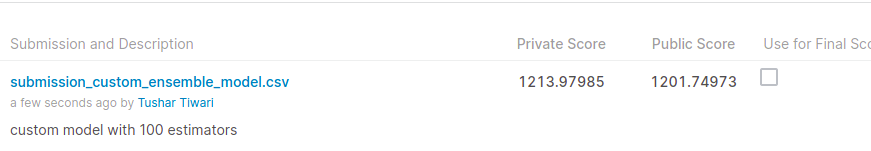

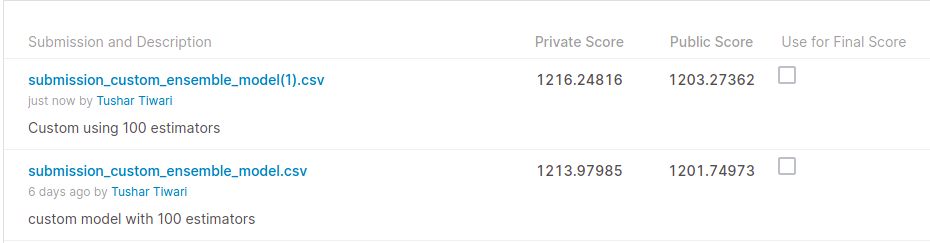